# TIME SERIES REGRESSION FAVORITA

In this project I will be assuming a role of a data scientist in Corporation Favorita, a large Ecuadorian-based grocery retailer. Corporation Favorita wants to ensure that they always have the right quantity of products in stock. To do this i have decided to build a series of machine learning models to forecast the demand of products in various locations. The marketing and sales team have provided some data to aid this endeavor. I will be using CRISP-DM Framework for this project.

## Business Understanding

It has always been a problem for companies to determine the right level of stock to have. There are a lot of factors to consider when it comes to stocking: lead times, cost of transportation, cost of warehousing, product lifespan and others.

Company's want to know the best level of stock to have in order to be able to satisfy customers demand whilst spend the lease possible amount on the stock.

Stock is company resources (money) held up, it is therefore prudent to be able to determine the right level of stock to hold. Policies like JIT(Just in time) and EOQ(Economic order quantities) have been utilised to manage stock levels.

Overstocking can lead to: locked up funds that could be used for other projects, expiry of goods, large/special warehouse spaces (which is costly), retailers like Favorita sometimes have to reduce prices of near-expiry products to cut down on losses. Some dangers of under-stocking could include disatisfied customers (which may lead to them voting with their feet), decrease in revenue, companies may also end up spending more on logistics when they understock frequently.

In this project we will be using machine learning and regression models to forecast sales which would help us determine stock levels to hold, the company believes this would be a more accurate policy since it is based on a large dataset of previous sales.

## Research questions

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Did the earthquake impact sales?
4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. Which product family and stores did the promotions affect.
8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
9. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
10. Compare the sales for each month across the years and determine which month of which year had the highest sales.

## Hypothesis

Null Hypothesis (H0): "There is no significant relationship between store sales and products promotions."

Alternative Hypothesis (Ha): "There is a significant relationship between store sales and products promotions."

In [103]:
#Data extraction and manipulation

import pyodbc    
from dotenv import dotenv_values
import pandas as pd
from itertools import product
import numpy as np


#Visualization and modelling
import matplotlib.dates as mdates
import calplot
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
#Utilities
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from matplotlib.ticker import FuncFormatter
#from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
#import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
import itertools
import warnings 
warnings.filterwarnings('ignore')
import os



In [14]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER_NAME")
database = environment_variables.get("DATABASE_NAME")
username = environment_variables.get("USER")
password = environment_variables.get("PASSWORD")

In [15]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [17]:

# Use the connect method of the pyodbc library and pass in the connection string.
connection = pyodbc.connect(connection_string)

In [18]:
# Sql query to retrieve data from Microsoft SQL database
oil_df = "SELECT * FROM dbo.oil"
#Execute the SQL queries and load the results into Pandas DataFrames
oil_df = pd.read_sql(oil_df, connection)
#Show retrieved table
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [19]:
# Sql query to retrieve data from Microsoft SQL database
holiday_events_df = "SELECT * FROM dbo.holidays_events"
#Execute the SQL queries and load the results into Pandas DataFrames
holiday_events_df = pd.read_sql(holiday_events_df, connection)
#Show retrieved table
holiday_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [20]:
# Sql query to retrieve data from Microsoft SQL database
store = "SELECT * FROM dbo.stores"
#Execute the SQL queries and load the results into Pandas DataFrames
store = pd.read_sql(store, connection)
#Show retrieved table
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [21]:
# close connection
connection.close()


In [22]:
train_df = pd.read_csv(r'C:\Users\User\Desktop\Azubi_Projects\TIME-SERIES-REGRESSION\Data\train.csv')

train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Exploratory Data Analysis


### Train Data Exploration


In [24]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [25]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [26]:
train_df.shape

(3000888, 6)

In [27]:
#Check unique observations 
train_df.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [28]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [29]:
train_df.duplicated().sum()

0

In [30]:
train_df['id'].unique().shape

(3000888,)

In [31]:
# Drop the id feature because it is not relevant to our analysis
train_df.drop(['id'],axis = 1, inplace=True)

In [32]:
train_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [33]:
# Change the dtype of the date column to a datetime
train_df['date'] = pd.to_datetime(train_df['date'])

In [34]:
# set the date columnas an index for better time series analysis
train_df.set_index('date').head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


### Check for completeness of data or missing values

In [35]:
train_df['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1684, dtype: datetime64[ns]

In [36]:
# Check for the erliest and lates date
actual_date = train_df['date'].min(),train_df['date'].max()
print(f' Start date:{actual_date[0]}\n End date: {actual_date[1]}')

 Start date:2013-01-01 00:00:00
 End date: 2017-08-15 00:00:00


In [37]:
date_range = pd.date_range(start = train_df['date'].min(), end = train_df['date'].max(), freq = 'D')
date_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [38]:
#The date_range for the start and end date is supposed to be 
date_range.size

1688

In [39]:
train_df['date'].unique().shape

(1684,)

In [40]:
# Find the missing days from date column of the train_df by using the differncr dates
missing_days = date_range.difference(train_df['date'])
missing_days

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

### Fill in values for the missing date by the family category

In [41]:
families = train_df['family'].unique()
print(f'Unique families in the train data is {families.size}')
families

Unique families in the train data is 33


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [42]:
#Check for the number of stores available
store_nbr = train_df['store_nbr'].unique()
print(f'Unique stores in train data is {store_nbr.size}')
store_nbr

Unique stores in train data is 54


array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)


### Key Insights on data completeness

1. There are no duplicates or null values in the train data
2. The date range between the start and end date is 1688 days, but there are only 1684 days in date column of train data
3. If there are only 1684 unique days in the train data, but the range difference between the first date and the last date is 1688, then it only stands that 4 days are missing
4. We need to add these 4 days to the dataframe and fill?interpolate the sales values for these 4 missing days.Because the sales for any given day is categorized into 
 - Families
 - Days 
 - Store_nbr
 

### Action Plan


1. Create the families for these 4 days for
2. Since there are 33 families, 54 stores and 4 missing dates, we will generate 7,128 new datapoints
 - 33x54x4(see unique values of these columns below)
 - Use the products class from itertools
  

### Create new data points for the missing dates

In [43]:

missing_data_points = product(missing_days, store_nbr, families)

# Create a dataframe from the product object generated
new_data = pd.DataFrame(data=missing_data_points, columns=["date", "store_nbr", "family"])
new_data.head()


,date,store_nbr,family
0,2013-12-25,1,AUTOMOTIVE
1,2013-12-25,1,BABY CARE
2,2013-12-25,1,BEAUTY
3,2013-12-25,1,BEVERAGES
4,2013-12-25,1,BOOKS


In [44]:
# Adding the new data to the original train data
# Note this introduces NaN in the sales and onpromotion columns
df = pd.concat([train_df,new_data],axis = 0)
df.set_index('date',inplace= True)
df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0.0
2013-01-01,1,BOOKS,0.0,0.0
...,...,...,...,...
2016-12-25,9,POULTRY,NaN,NaN
2016-12-25,9,PREPARED FOODS,NaN,NaN
2016-12-25,9,PRODUCE,NaN,NaN


In [45]:
# Check null values again and the new generated data points should have the sales and onpromotion columns having null values
df.isna().sum()

store_nbr         0
family            0
sales          7128
onpromotion    7128
dtype: int64

In [46]:
# Double check to make sure there are no missing values
missing_days = set(date_range) - set(df.index.unique())
missing_days

set()

In [47]:
# Lets check the size again
df.shape 

(3008016, 4)

In [48]:
# Change NaN values for the salesand onpromotion columns to 0
df['sales'] = df['sales'].fillna(0)
df['onpromotion'] = df['onpromotion'].fillna(0)

In [49]:
df.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [50]:
# Sort date columns to be in acsending order from start date to end date(end date is 15th august 2017)
df.sort_index(inplace = True)
df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0.0
2013-01-01,42,CELEBRATION,0.000,0.0
2013-01-01,42,BREAD/BAKERY,0.000,0.0
2013-01-01,42,BOOKS,0.000,0.0
2013-01-01,42,BEVERAGES,0.000,0.0
...,...,...,...,...
2017-08-15,25,POULTRY,172.517,0.0
2017-08-15,25,PLAYERS AND ELECTRONICS,3.000,0.0
2017-08-15,25,PET SUPPLIES,3.000,0.0


### To note after making sure there are no missing dates

1. Data set completed with 3,008,016 records 
2. The sales and onpromotion columns that was added from the new data points that was generated is all NaN which we are going ton fill with 0.

### Univeriate Analysis

In [51]:
# Print unique values for each column
for column in df.columns:
    print(f'Column Name: {column}\n')
    print(f'Number of unique values: {df[column].unique().size}\n')
    print(f'{df[column].unique()}')
    print('%' * 80)

Column Name: store_nbr

Number of unique values: 54

[ 1 42 41 43 40  4 45 44 46 36 35 37 34 39 38 54  6 53 52  9  8  7 48 49
 47 51 50  5 33 18 17 19 16 15 20  2 21 11 10 12 14 13  3 29 30 28 32 31
 23 24 22 27 26 25]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Column Name: family

Number of unique values: 33

['AUTOMOTIVE' 'CELEBRATION' 'BREAD/BAKERY' 'BOOKS' 'BEVERAGES' 'BEAUTY'
 'BABY CARE' 'SEAFOOD' 'SCHOOL AND OFFICE SUPPLIES' 'PRODUCE'
 'PREPARED FOODS' 'POULTRY' 'PLAYERS AND ELECTRONICS' 'PET SUPPLIES'
 'PERSONAL CARE' 'MEATS' 'MAGAZINES' 'LIQUOR,WINE,BEER' 'LINGERIE'
 'LAWN AND GARDEN' 'LADIESWEAR' 'HOME CARE' 'HOME APPLIANCES' 'CLEANING'
 'DAIRY' 'DELI' 'EGGS' 'HOME AND KITCHEN II' 'HOME AND KITCHEN I'
 'HARDWARE' 'GROCERY II' 'GROCERY I' 'FROZEN FOODS']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Column Name: sales

Number of unique values: 379610

[   0.      15.     700.    ...  382.93   385.94  1269

In [52]:
# Change the format of the sales column from scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [53]:
# Assuming your DataFrame is named df
df.drop('family', axis=1).skew().rename('Skewness').reset_index()

,index,Skewness
0,store_nbr,0.00
1,sales,7.37
2,onpromotion,11.18


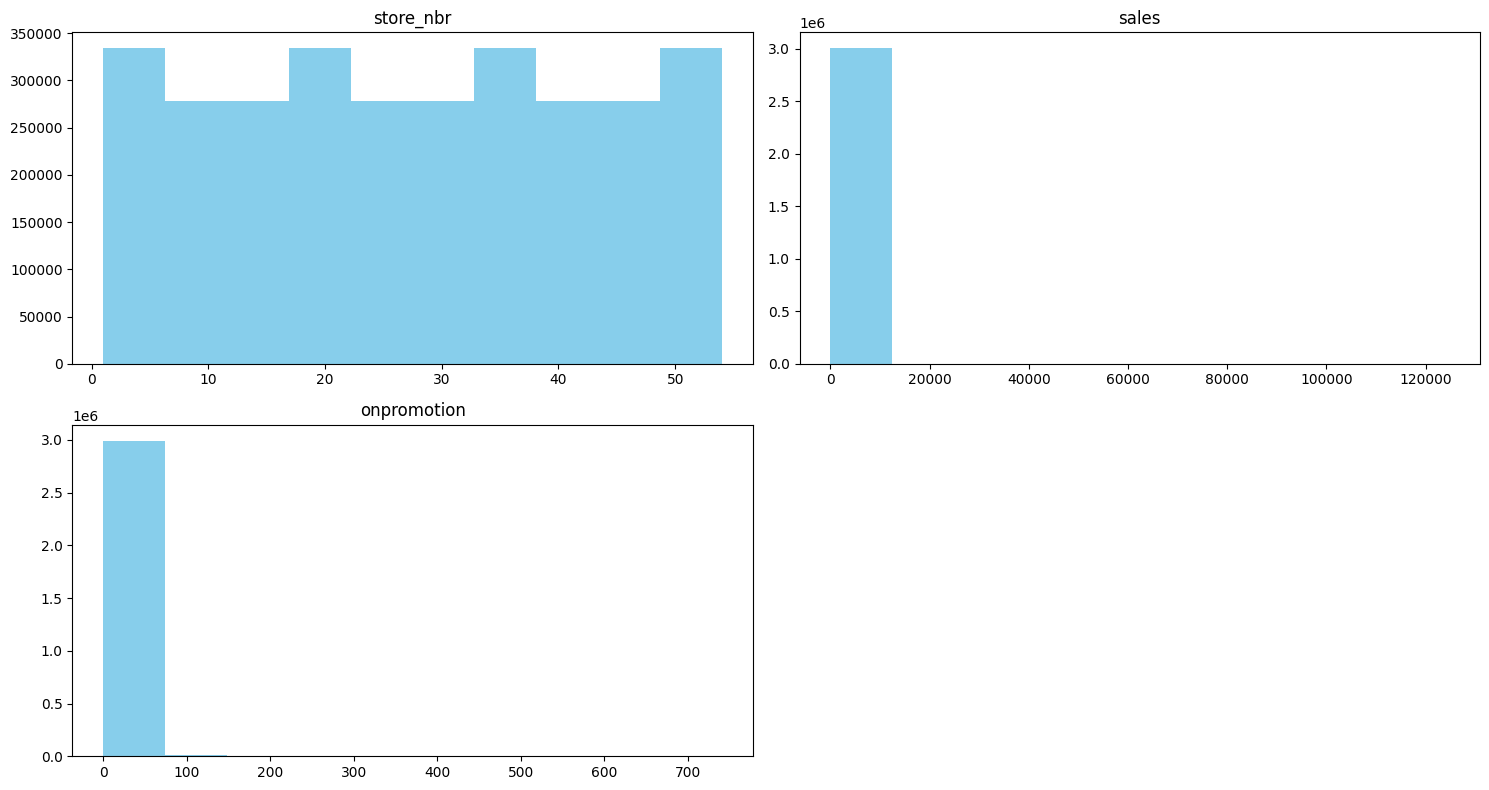

In [54]:
df.hist(figsize = (15,8), color = 'skyblue',grid= False)
plt.tight_layout()
plt.show()


In [55]:

df

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00
2013-01-01,42,CELEBRATION,0.00,0.00
2013-01-01,42,BREAD/BAKERY,0.00,0.00
2013-01-01,42,BOOKS,0.00,0.00
2013-01-01,42,BEVERAGES,0.00,0.00
...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00
2017-08-15,25,PET SUPPLIES,3.00,0.00


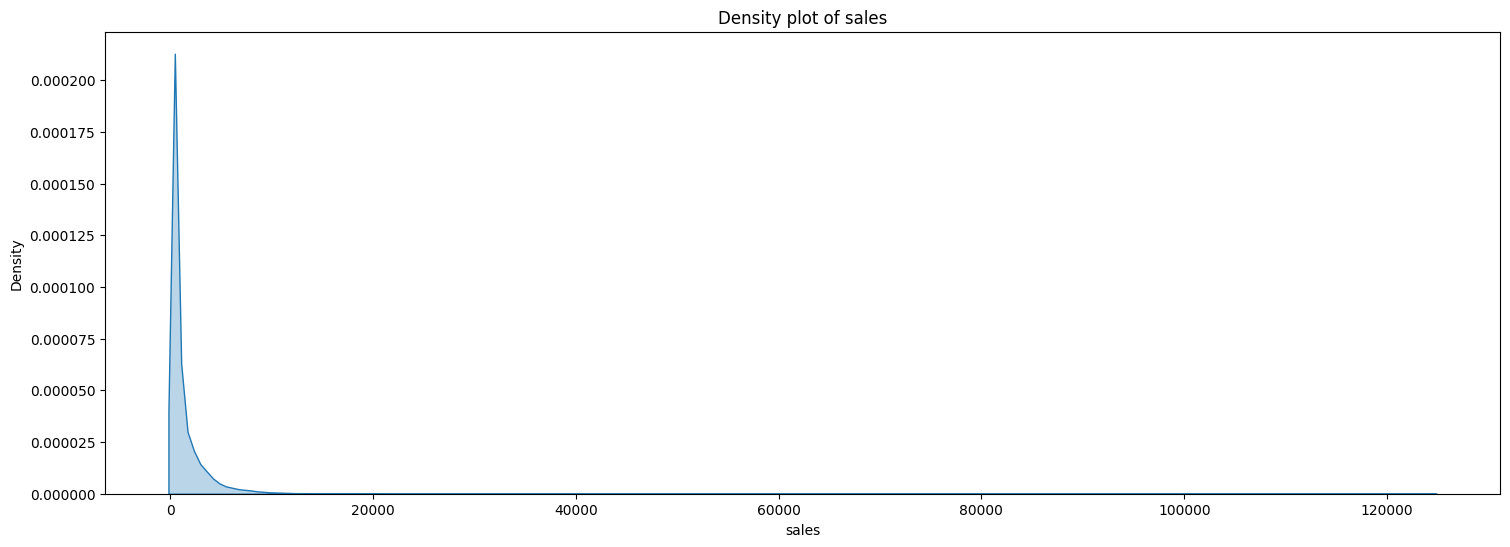

In [56]:
plt.figure(figsize=(18, 6))
sns.kdeplot(df['sales'], fill=True, alpha=0.3)
plt.title('Density plot of sales')
plt.show()

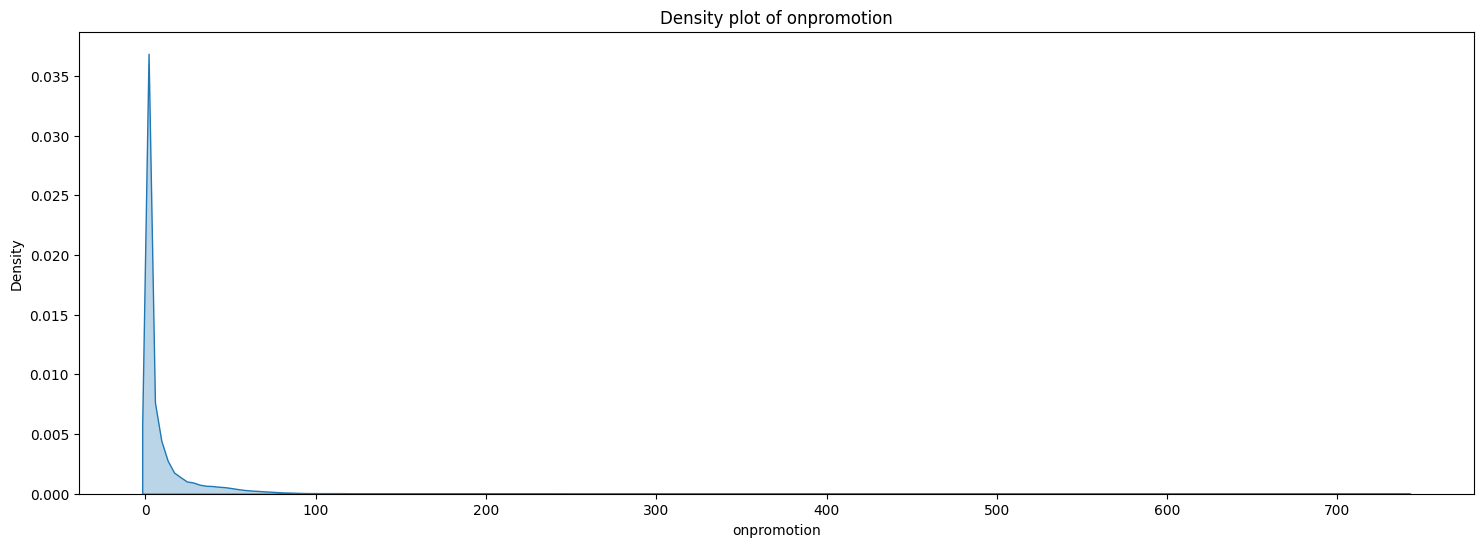

In [57]:


plt.figure(figsize=(18, 6))
sns.kdeplot(df['onpromotion'], fill=True, alpha=0.3)
plt.title('Density plot of onpromotion')
plt.show()


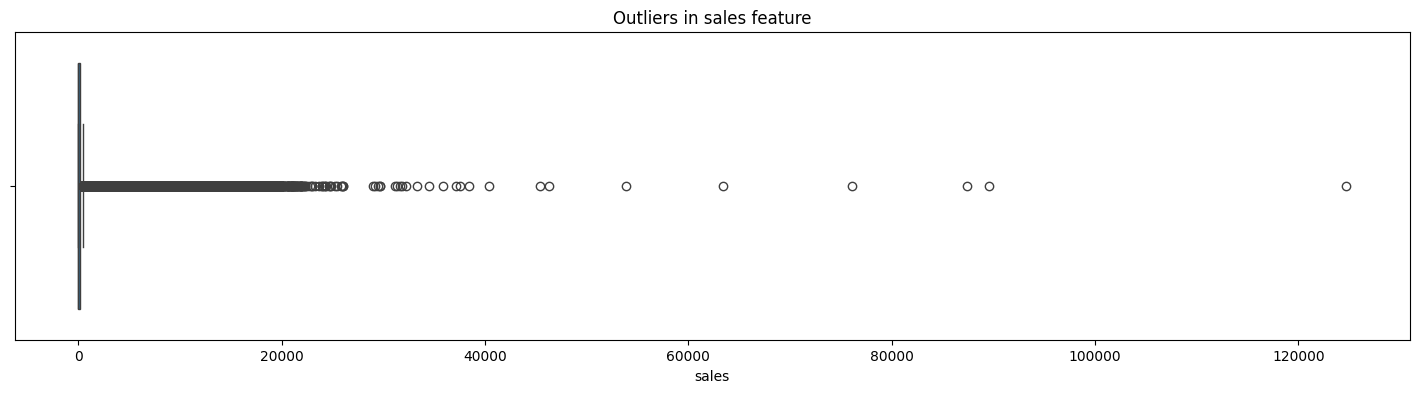

In [58]:
plt.figure(figsize =(18,4))
sns.boxplot(df['sales'], orient ='h')
plt.title('Outliers in sales feature')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

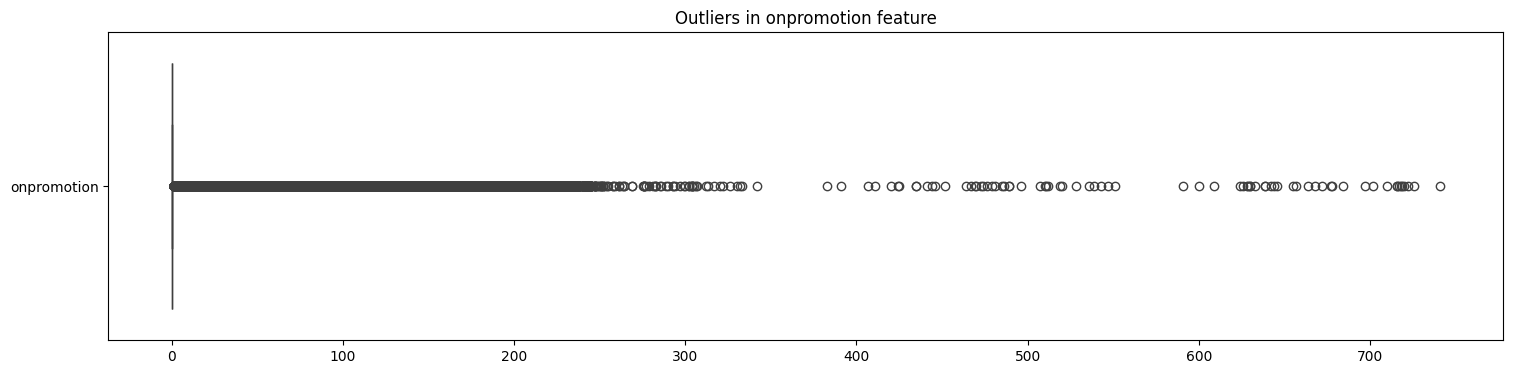

In [59]:
plt.figure(figsize = (18, 4))
sns.boxplot(df.drop(['sales','store_nbr'],axis = 1),orient = 'h')
plt.title('Outliers in onpromotion feature')
plt.show

. Anomalies Detection (Optional)
Identify any anomalies or outliers in the sales data
Investigate potential causes for anomalies

### Biveriate Analysis

In [60]:
# Create new features to check for better correlation
def create_new_features(df):
    df['month_name'] = df.index.month_name()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day'] = df.index.dayofweek
    
    return df
df = create_new_features(df)
df

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1
...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,1
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,1
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,1


In [61]:
# Create a correlation heatmap
correlation = df.drop(['family','month_name'], axis = 1).corr()
correlation

,store_nbr,sales,onpromotion,month,year,day
store_nbr,1.00,0.04,0.01,0.00,-0.00,-0.00
sales,0.04,1.00,0.43,0.02,0.08,0.04
onpromotion,0.01,0.43,1.00,0.02,0.20,-0.00
month,0.00,0.02,0.02,1.00,-0.14,-0.00
year,-0.00,0.08,0.20,-0.14,1.00,0.00
day,-0.00,0.04,-0.00,-0.00,0.00,1.00


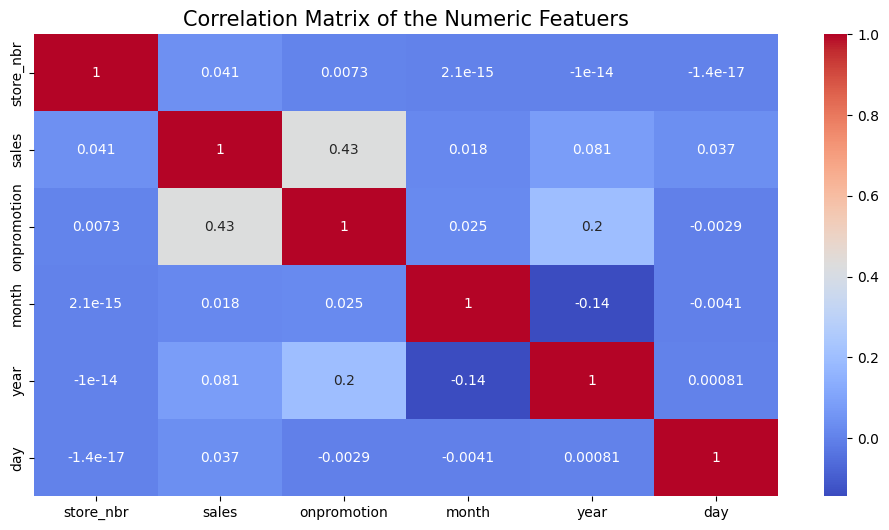

In [62]:
plt.figure(figsize = (12, 6))
sns.heatmap(correlation, annot=True, cmap = 'coolwarm')
plt.title('Correlation Matrix of the Numeric Featuers', fontsize =15)
plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


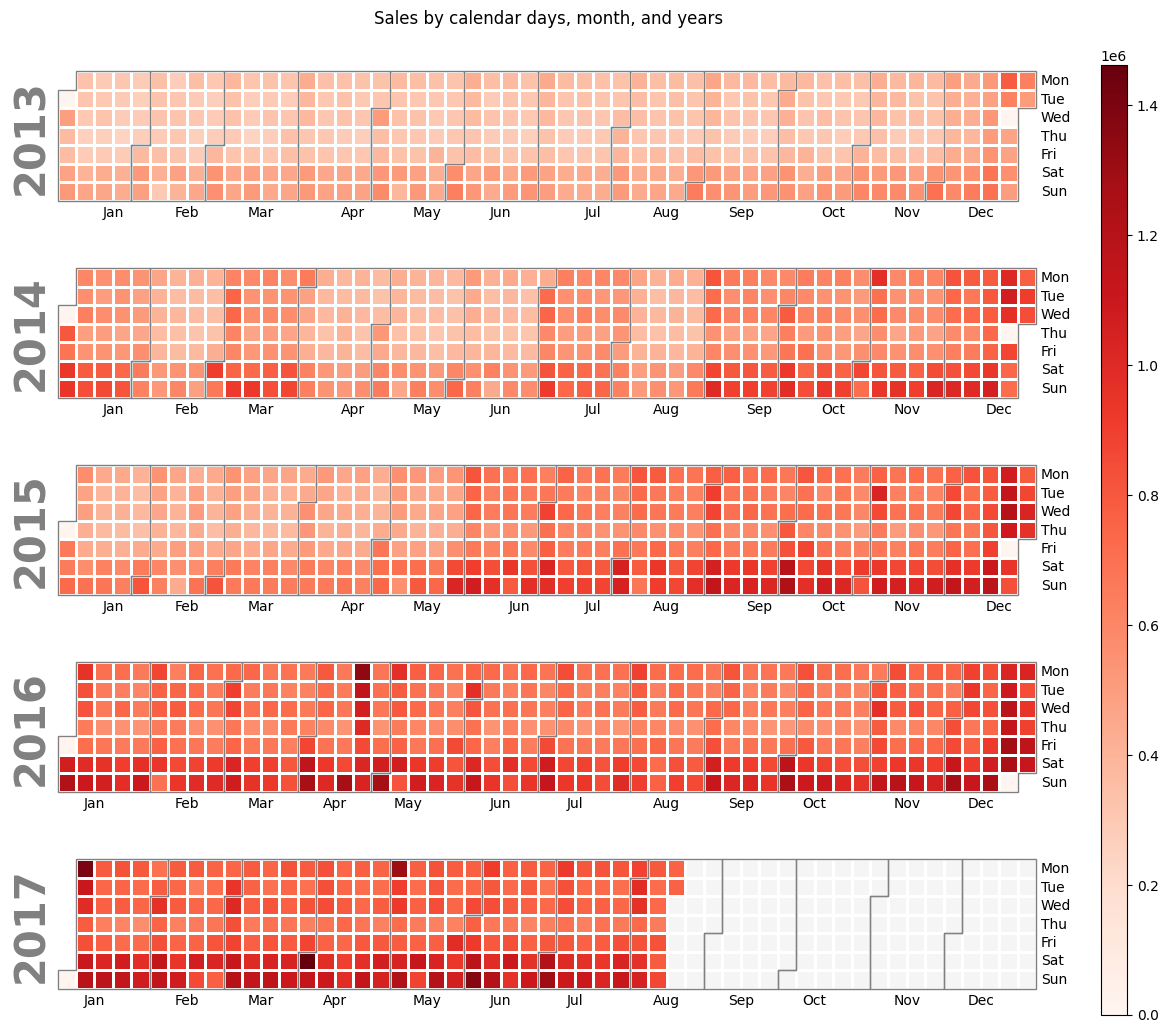

In [65]:


# Assuming df is your DataFrame containing the sales data
calplot.calplot(df['sales'], how='sum', cmap='Reds', figsize=(13, 10), suptitle='Sales by calendar days, month, and years')
plt.show()



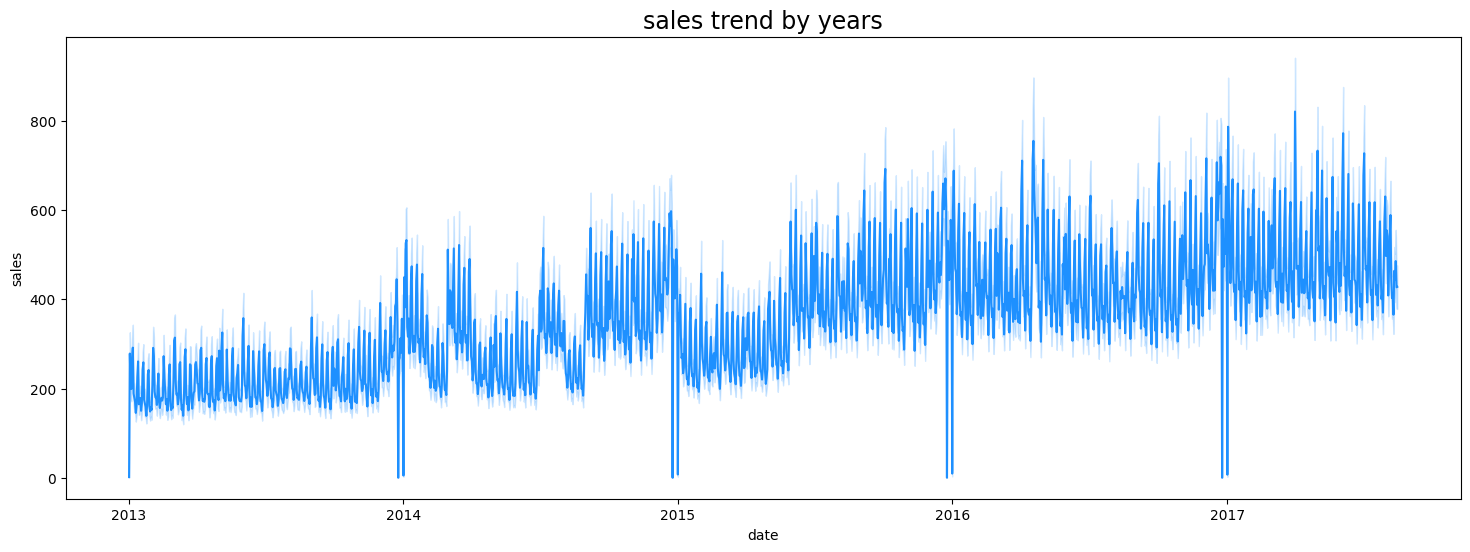

In [66]:
plt.figure(figsize=(18, 6))
sns.lineplot(data =df, x = df.index,y ='sales',color = 'dodgerblue')
plt.title('sales trend by years', fontsize = 17)
plt.show()

### Decomposition

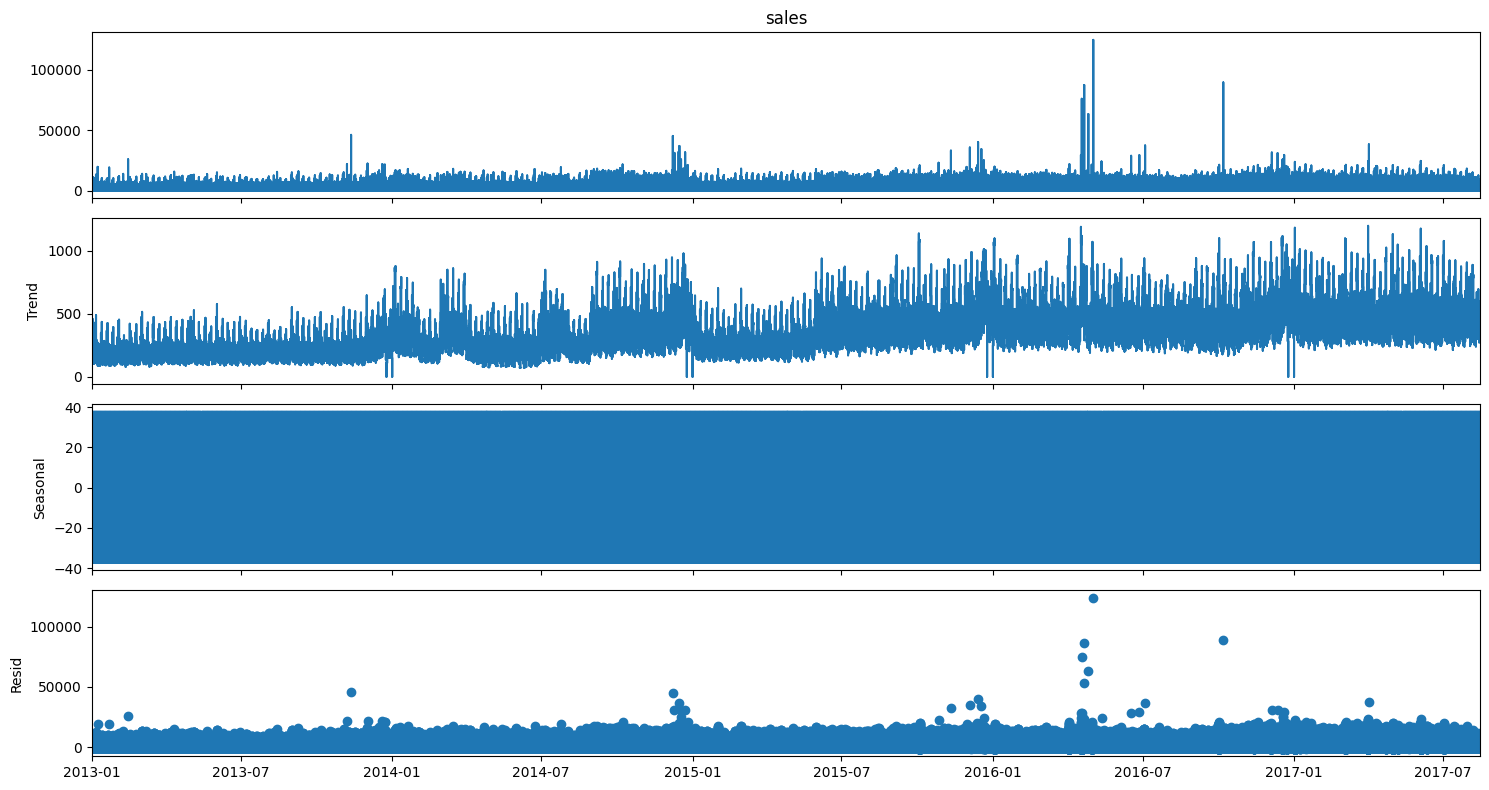

In [67]:


# Assuming df is your DataFrame containing the sales data
results = seasonal_decompose(df['sales'], model='additive', period=365)
plt.rcParams.update({'figure.figsize': (15, 8)})
results.plot()
plt.show()



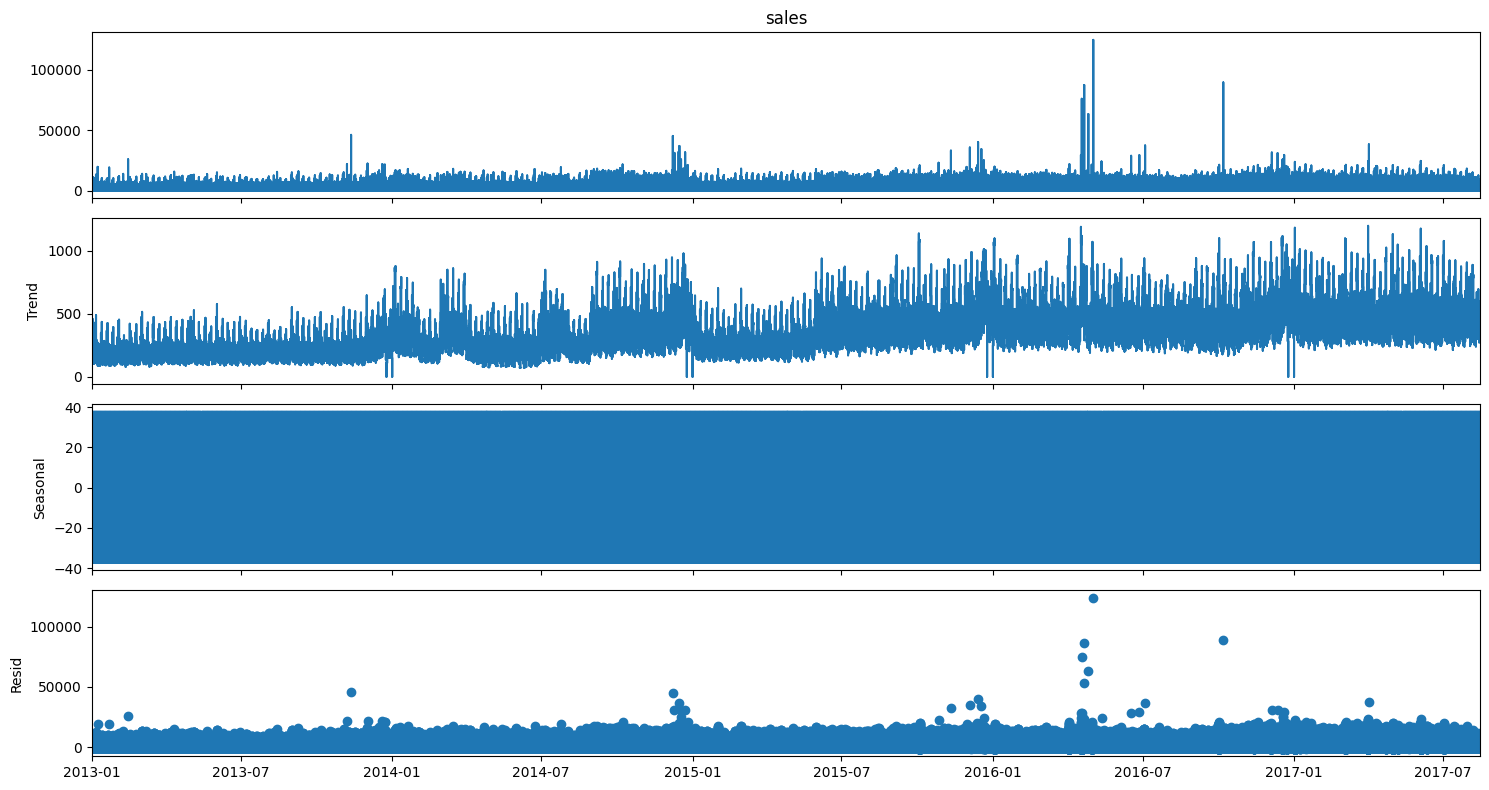

In [68]:


# Assuming df is your DataFrame containing the sales data
results = seasonal_decompose(df['sales'], model='additive', period=365)
plt.rcParams.update({'figure.figsize': (15, 8)})
results.plot()
plt.show()


In [69]:
# Extract components and create a new dataframe
decomposition_df = pd.DataFrame({
    'Trend': results.trend,
    'Seasonality': results.seasonal,
    'Residual': results.resid,
    'Observed': results.observed,
})
decomposition_df



,Trend,Seasonality,Residual,Observed
date,,,,
2013-01-01,NaN,9.23,NaN,0.00
2013-01-01,NaN,-3.24,NaN,0.00
2013-01-01,NaN,-5.17,NaN,0.00
2013-01-01,NaN,-10.93,NaN,0.00
2013-01-01,NaN,-5.84,NaN,0.00
...,...,...,...,...
2017-08-15,NaN,13.01,NaN,172.52
2017-08-15,NaN,13.57,NaN,3.00
2017-08-15,NaN,-7.78,NaN,3.00


In [70]:
decomposition_df.tail(1000)

,Trend,Seasonality,Residual,Observed
date,,,,
2017-08-15,549.31,-18.79,-312.64,217.89
2017-08-15,549.15,-3.12,830.97,1377.00
2017-08-15,551.85,-9.34,814.49,1357.00
2017-08-15,552.01,8.28,-544.29,16.00
2017-08-15,552.34,-13.90,166.36,704.80
...,...,...,...,...
2017-08-15,NaN,13.01,NaN,172.52
2017-08-15,NaN,13.57,NaN,3.00
2017-08-15,NaN,-7.78,NaN,3.00


In [71]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1


### Stationary Testing

- Due to the size of the dataset, down size the data by converting my daily data to weekly data
- Aggregate the means of the 7 days of the week

In [72]:
# resample and calculate the mean only on the sales column
df_downsampled = df[['sales']].resample('W').mean()

#Check if there are NaN values and handle them appropriately
df_downsampled.fillna(0, inplace=True)

df_downsampled

,sales
date,
2013-01-06,206.84
2013-01-13,190.29
2013-01-20,189.84
2013-01-27,182.15
2013-02-03,198.56
...,...
2017-07-23,460.50
2017-07-30,474.73
2017-08-06,513.88


In [73]:
# Use the ADF to calculate the stationarity in sales
result = adfuller(df_downsampled['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -1.481750917756024
p-value: 0.5425188110982654
Data is not stationary


In [74]:
result

(-1.481750917756024,
 0.5425188110982654,
 13,
 228,
 {'1%': -3.4593607492757554,
  '5%': -2.8743015807562924,
  '10%': -2.5735714042782396},
 2278.6898598939215)

### Visualizing stationarity using Rolling statistics

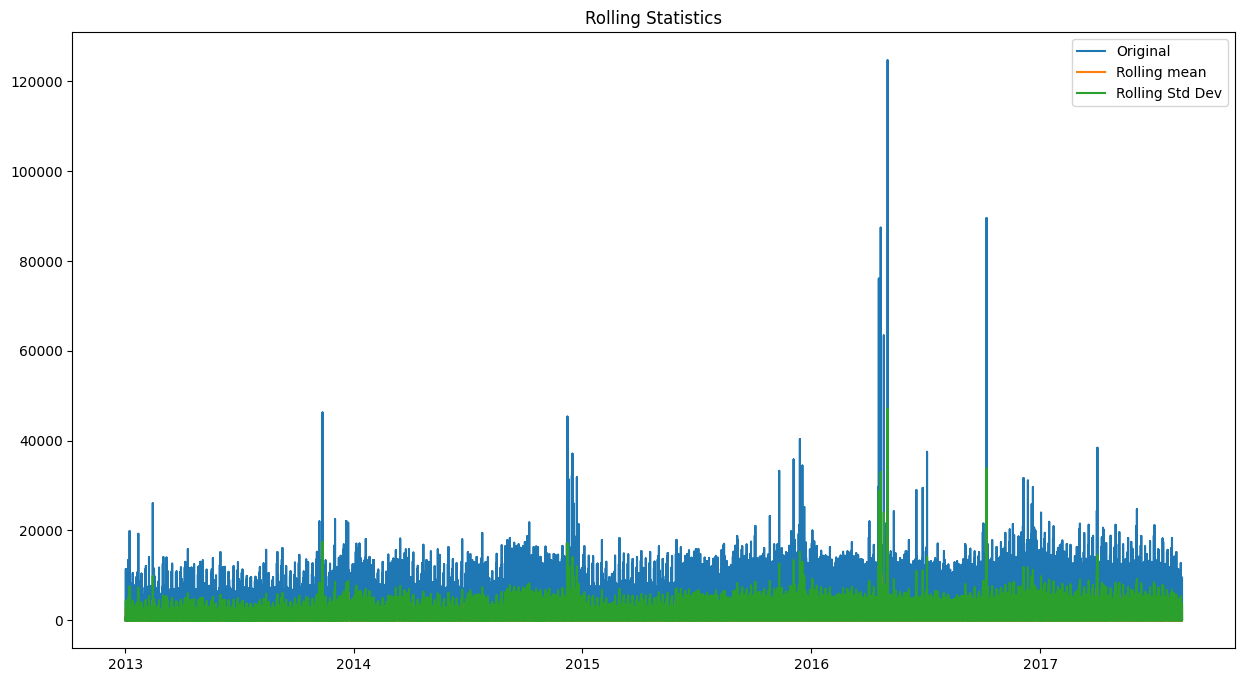

In [75]:
# Rolling mean and std dev
rolling_mean = df['sales'].rolling(window=7).mean()
rolling_std = df['sales'].rolling(window=7).std()

plt.plot(df['sales'], label ='Original')
plt.plot(rolling_mean, label = 'Rolling mean')
plt.plot(rolling_std, label = 'Rolling Std Dev')
plt.legend(loc ='best')
plt.title('Rolling Statistics')
plt.show()

### Key Insights - Visualization

1. The sales and onpromotion columns are heavily skewed with alot of outliers
2. The data is not Stationary which means it does not maintain a constant mean, variance and co-variance over time

### Answering Analytical Questions 
#### Research questions

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Did the earthquake impact sales?
4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. What analysis can we get from the date and its extractable features?
7. Which product family and stores did the promotions affect.
8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
9. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
10. Compare the sales for each month across the years and determine which month of which year had the highest sales.

1. Is the train dataset complete(has all required dates)?

- This question was answered during the checking for data completeness earlier in the notebook.
- There were 4 missing days from the range given in the train dataset



2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

i. Group sales by date

In [78]:
sales_df = df.groupby('date')['sales'].sum().reset_index()
sales_df

,date,sales
0,2013-01-01,2511.62
1,2013-01-02,496092.42
2,2013-01-03,361461.23
3,2013-01-04,354459.68
4,2013-01-05,477350.12
...,...,...
1683,2017-08-11,826373.72
1684,2017-08-12,792630.54
1685,2017-08-13,865639.68
1686,2017-08-14,760922.41


In [79]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1


In [80]:
original_df = df.copy()


In [81]:
original_df['sales_date'] = original_df.index

In [82]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [83]:
# Filter out days when the store was closed (zero sales)
filt_df = df[df['sales'] > 0]
filt_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,25,GROCERY II,15.00,0.00,January,1,2013,1
2013-01-01,25,GROCERY I,700.00,0.00,January,1,2013,1
2013-01-01,25,FROZEN FOODS,29.65,0.00,January,1,2013,1
2013-01-01,25,DELI,71.09,0.00,January,1,2013,1
2013-01-01,25,DAIRY,143.00,0.00,January,1,2013,1


In [84]:
closed_days = df[df['sales'] > 0]
closed_days.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day
date,,,,,,,,
2013-01-01,25,GROCERY II,15.00,0.00,January,1,2013,1
2013-01-01,25,GROCERY I,700.00,0.00,January,1,2013,1
2013-01-01,25,FROZEN FOODS,29.65,0.00,January,1,2013,1
2013-01-01,25,DELI,71.09,0.00,January,1,2013,1
2013-01-01,25,DAIRY,143.00,0.00,January,1,2013,1


ii. Aggregate sales by date and year

In [85]:


# Reset index to convert 'date' from index to a column
filt_df.reset_index(inplace=True)

# Convert 'date' column to datetime format
filt_df['date'] = pd.to_datetime(filt_df['date'])

# Extract year from the 'date' column
filt_df['year'] = filt_df['date'].dt.year

# Aggregate sales by date and year
sales_by_date_year = filt_df.groupby(['year', 'date'])['sales'].sum().reset_index()

# Find the dates with the lowest and highest sales for each year
lowest_sales_dates = sales_by_date_year.loc[sales_by_date_year.groupby('year')['sales'].idxmin()]
highest_sales_dates = sales_by_date_year.loc[sales_by_date_year.groupby('year')['sales'].idxmax()]

# Format sales numbers as comma-separated with two decimal places
lowest_sales_dates['sales'] = lowest_sales_dates['sales'].apply(lambda x: '{:,.2f}'.format(x))
highest_sales_dates['sales'] = highest_sales_dates['sales'].apply(lambda x: '{:,.2f}'.format(x))

print("Dates with lowest sales for each year:")
print(lowest_sales_dates)

print("\nDates with highest sales for each year:")
print(highest_sales_dates)



Dates with lowest sales for each year:
      year       date      sales
0     2013 2013-01-01   2,511.62
364   2014 2014-01-01   8,602.07
728   2015 2015-01-01  12,773.62
1092  2016 2016-01-01  16,433.39
1457  2017 2017-01-01  12,082.50

Dates with highest sales for each year:
      year       date         sales
356   2013 2013-12-23    792,865.28
720   2014 2014-12-23  1,064,977.97
1004  2015 2015-10-04  1,234,130.94
1200  2016 2016-04-18  1,345,920.60
1547  2017 2017-04-01  1,463,083.96


3. Did the earthquake impact sales?

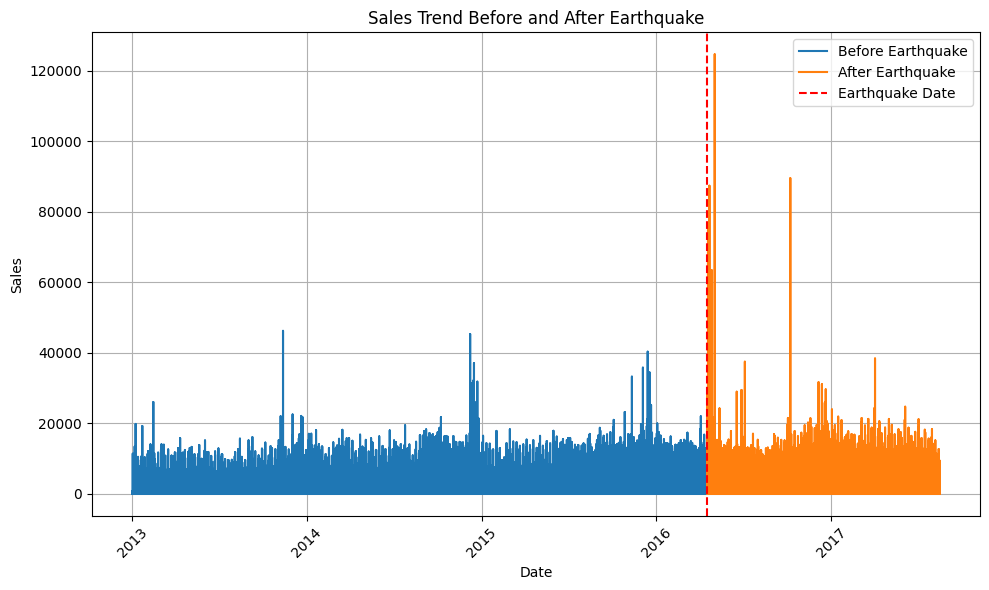

Sales did not significantly change after the earthquake.


In [86]:


# Check for sales trend before and after the earthquake
earthquake_date = '2016-04-16'
before_earthquake_data = df[df.index < earthquake_date]
after_earthquake_data = df[df.index > earthquake_date]

# Calculate mean sales before and after the earthquake
before_earthquake_sales = before_earthquake_data['sales'].mean()
after_earthquake_sales = after_earthquake_data['sales'].mean()

# Create a line plot to visualize sales trend before and after the earthquake
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_data.index, before_earthquake_data['sales'], label='Before Earthquake')
plt.plot(after_earthquake_data.index, after_earthquake_data['sales'], label='After Earthquake')
plt.axvline(x=pd.to_datetime(earthquake_date), color='red', linestyle='--', label='Earthquake Date')
plt.title('Sales Trend Before and After Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the comparison result
if before_earthquake_sales > after_earthquake_sales:
    print("Sales decreased after the earthquake.")
else:
    print("Sales did not significantly change after the earthquake.")


4. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

- Merge df to store_df get access to cluster, city, state and type
- visualize each category

In [87]:
merged_df = pd.merge(df, store,on ='store_nbr', how = 'inner')
merged_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Quito,Pichincha,D,13
1,42,CELEBRATION,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
2,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
3,42,BOOKS,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
4,42,BEVERAGES,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2


In [88]:
merged_df['state'].unique()

array(['Pichincha', 'Azuay', 'El Oro', 'Esmeraldas', 'Guayas', 'Loja',
       'Manabi', 'Tungurahua', 'Santo Domingo de los Tsachilas',
       'Los Rios', 'Bolivar', 'Imbabura', 'Cotopaxi', 'Chimborazo',
       'Pastaza', 'Santa Elena'], dtype=object)

In [89]:
merged_df['state'].nunique()

16

### Sales by state

In [90]:
sales_by_state =merged_df.groupby(['state'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_state

,state,sales
12,Pichincha,585067395.31
6,Guayas,165154392.38
0,Azuay,49168596.03
15,Tungurahua,40304401.30
14,Santo Domingo de los Tsachilas,35834323.04
4,El Oro,33386796.54
9,Los Rios,31925373.99
10,Manabi,24969820.13
3,Cotopaxi,21182263.78
8,Loja,18859999.26


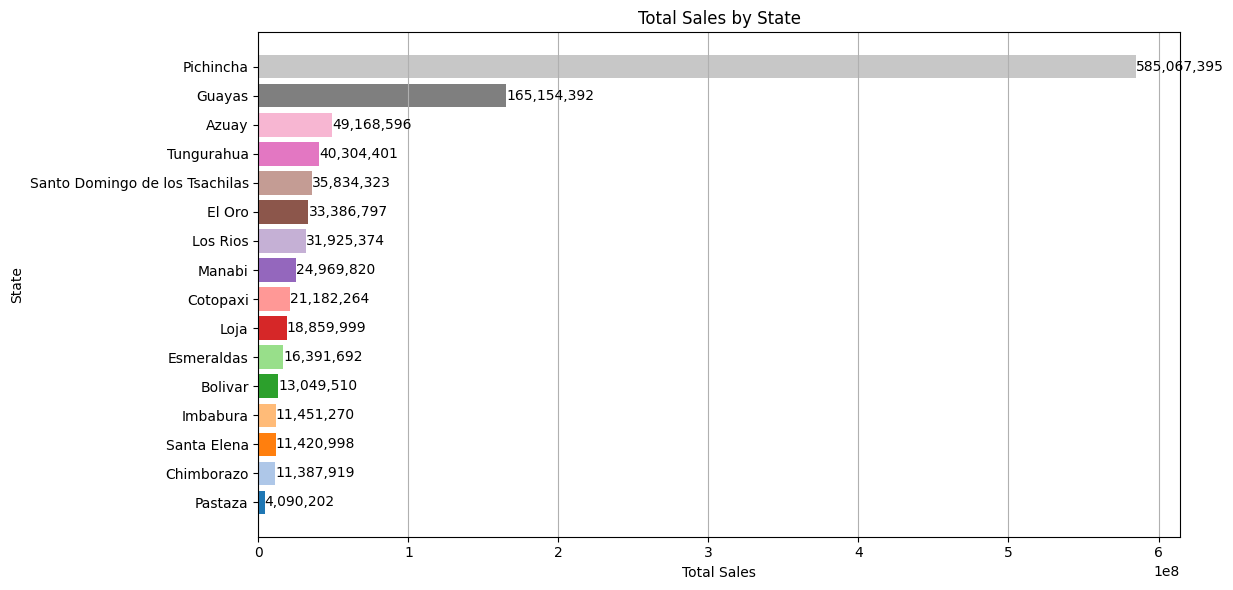

In [92]:


# Sort the data by sales in descending order
sales_by_state_sorted = sales_by_state.sort_values(by='sales', ascending=True)

# Generate a range of colors using a colormap
colors = plt.cm.tab20.colors[:len(sales_by_state_sorted)]

# Visualize state by sales
plt.figure(figsize=(12, 6))
bars = plt.barh(sales_by_state_sorted['state'], sales_by_state_sorted['sales'], color=colors)
plt.title('Total Sales by State')
plt.xlabel('Total Sales')
plt.ylabel('State')
plt.grid(axis='x')  # Change grid to align with x-axis in horizontal bars
plt.tight_layout()

# Add value annotations with commas for thousands
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:,.0f}', 
             ha='left', va='center')

plt.show()


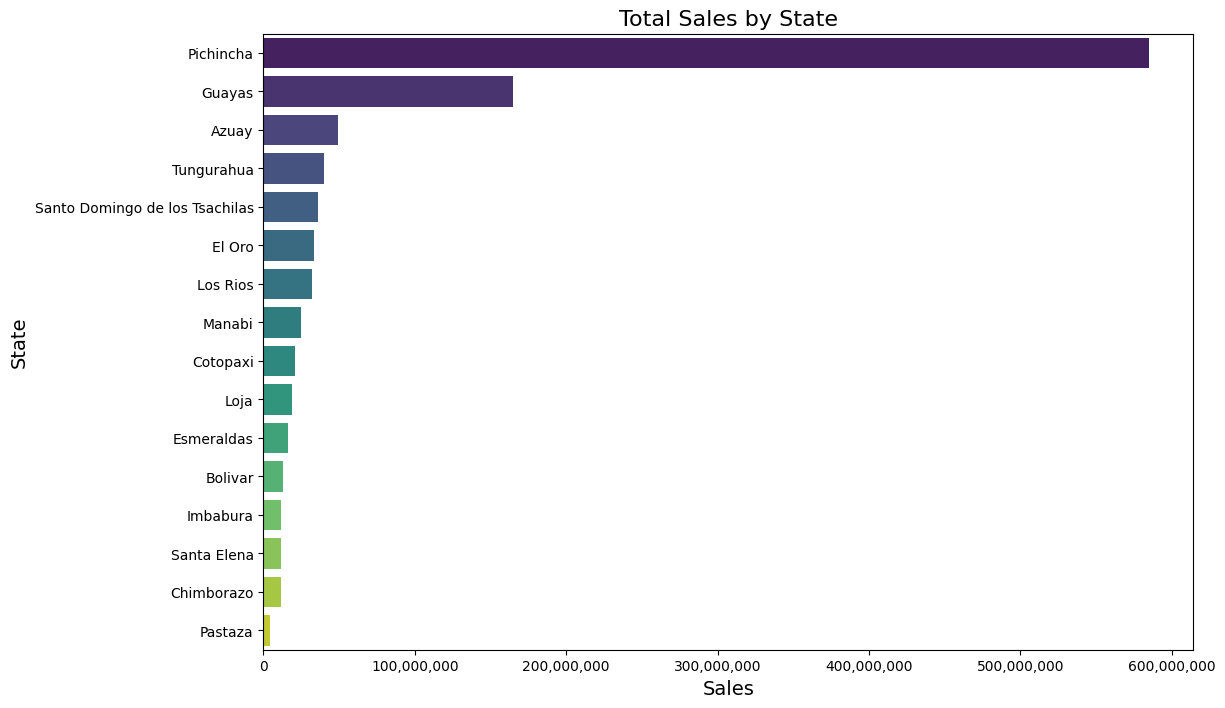

In [95]:
# Your data
data = sales_by_state

# Create DataFrame
sales_by_state = pd.DataFrame(data)

# Create bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=sales_by_state, x='sales', y='state', palette='viridis')

# Add labels
plt.xlabel('Sales', fontsize=14)
plt.ylabel('State', fontsize=14)  # Corrected ylabel from 'state' to 'State'
plt.title('Total Sales by State', fontsize=16)

# Format x-axis to add comma separators
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.show()


### Sales by City 

In [97]:
merged_df['city'].unique()

array(['Quito', 'Cuenca', 'Machala', 'Esmeraldas', 'Libertad', 'Playas',
       'Guayaquil', 'Loja', 'El Carmen', 'Manta', 'Ambato',
       'Santo Domingo', 'Quevedo', 'Guaranda', 'Ibarra', 'Cayambe',
       'Latacunga', 'Riobamba', 'Babahoyo', 'Puyo', 'Daule', 'Salinas'],
      dtype=object)

In [98]:
merged_df['city'].nunique()

22

In [99]:
sales_by_city=merged_df.groupby(['city'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_city

,city,sales
18,Quito,556741836.83
8,Guayaquil,122967260.48
3,Cuenca,49168596.03
0,Ambato,40304401.30
21,Santo Domingo,35834323.04
13,Machala,33386796.54
2,Cayambe,28325558.48
10,Latacunga,21182263.78
4,Daule,19188021.38
12,Loja,18859999.26


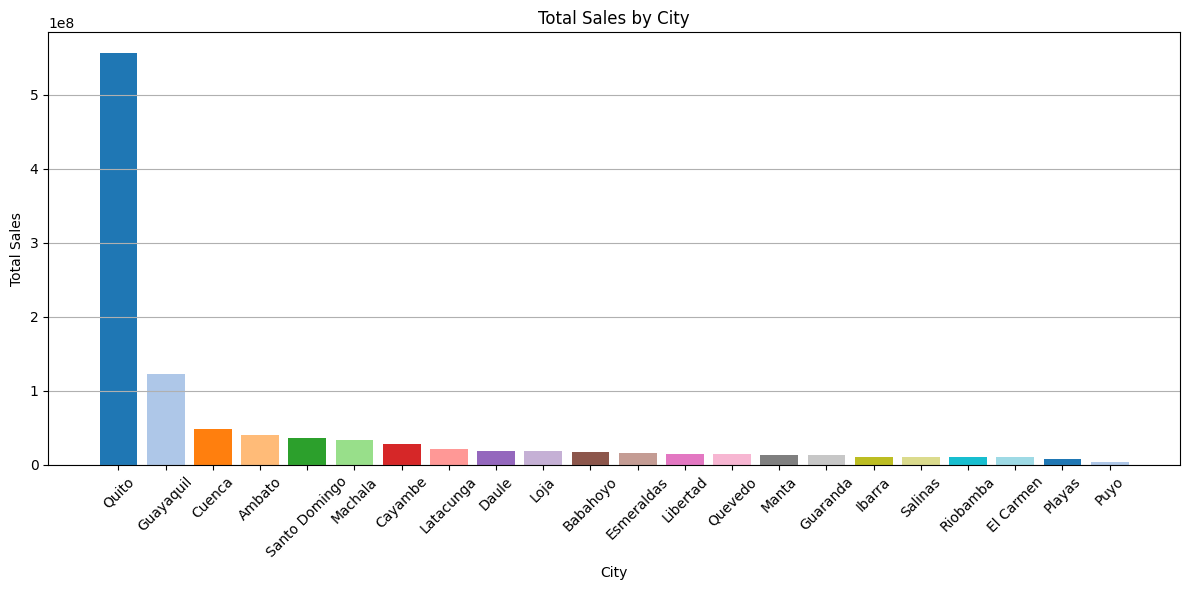

In [100]:


# Create a list of unique colors for each bar
colors = plt.cm.tab20.colors[:len(sales_by_city)]

# Visualize sales by city
plt.figure(figsize=(12, 6))
plt.bar(sales_by_city['city'], sales_by_city['sales'], color=colors)
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Sales by Cluster 


In [101]:
sales_by_cluster=merged_df.groupby(['cluster'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_cluster

,cluster,sales
13,14,157430523.08
5,6,114254386.74
7,8,107928246.70
10,11,100614275.93
9,10,85324430.43
2,3,75628703.46
12,13,72102248.79
4,5,62087553.25
14,15,55296949.37
0,1,54376751.96


In [106]:
sales_by_type = merged_df.groupby(['type'])['sales'].sum().reset_index().sort_values(by ='sales',ascending = False)
sales_by_type

,type,sales
0,A,353043841.80
3,D,351083296.86
2,C,164434742.56
1,B,145260635.13
4,E,59822435.84


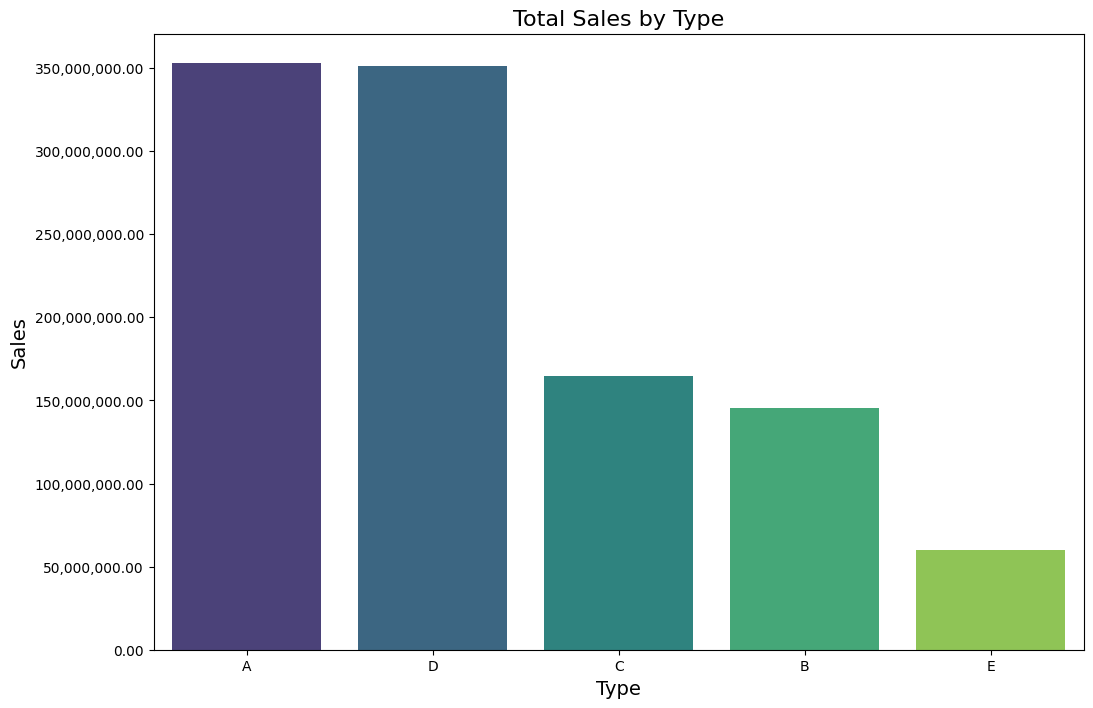

In [107]:
sales_by_type = pd.DataFrame(sales_by_type)

# Create bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=sales_by_type, x='type', y='sales', palette='viridis')

# Add labels
plt.xlabel('Type', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.title('Total Sales by Type', fontsize=16)

# Format y-axis to add comma separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

plt.show()



5. Are sales affected by promotions, oil prices and holidays?

### Promotion analysis

In [108]:
df = merged_df

In [109]:
df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,city,state,type,cluster
0,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,Quito,Pichincha,D,13
1,42,CELEBRATION,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
2,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
3,42,BOOKS,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2
4,42,BEVERAGES,0.00,0.00,January,1,2013,1,Cuenca,Azuay,D,2


In [110]:
no_promotion_df = df[df['onpromotion'] == 0]

# Format with commas using an f-string
no_promotion_data_points = f'{no_promotion_df.shape[0]:,}'
print(f'Number of datapoints with no promotion is {no_promotion_data_points}')

Number of datapoints with no promotion is 2,396,687


In [111]:
promotion_df = df[df['onpromotion'] > 0]

# Format with commas using an f-string
promotion_data_points = f'{promotion_df.shape[0]:,}'
print(f'Number of datapoints with promotion is {promotion_data_points}')

Number of datapoints with promotion is 611,329


In [112]:
no_promotion_df = df[df['onpromotion'] == 0]
no_promotion_df = no_promotion_df.groupby('family')['sales'].sum().reset_index().sort_values('sales', ascending=False)
# Add thousands seperatorto sales column
no_promotion_df['sales_format'] = no_promotion_df['sales'].apply(lambda x: f'{x:,.0f}')
no_promotion_df = no_promotion_df.nlargest(10,'sales')
no_promotion_df



,family,sales,sales_format
12,GROCERY I,92538393.70,"92,538,394"
3,BEVERAGES,50697146.00,"50,697,146"
30,PRODUCE,47646514.14,"47,646,514"
7,CLEANING,35634773.00,"35,634,773"
28,POULTRY,22319444.02,"22,319,444"
8,DAIRY,21567990.00,"21,567,990"
24,MEATS,21054436.99,"21,054,437"
5,BREAD/BAKERY,19749869.49,"19,749,869"
25,PERSONAL CARE,11641426.00,"11,641,426"
9,DELI,11411278.33,"11,411,278"


In [113]:
promotion_df = df[df['onpromotion'] > 0]
promotion_df = promotion_df.groupby('family')['sales'].sum().reset_index().sort_values('sales', ascending=False)
# Add thousands seperatorto sales column
promotion_df['sales_format'] = promotion_df['sales'].apply(lambda x: f'{x:,.0f}')
promotion_df = promotion_df.nlargest(10,'sales')
promotion_df

,family,sales,sales_format
11,GROCERY I,250924341.19,"250,924,341"
3,BEVERAGES,166257340.00,"166,257,340"
29,PRODUCE,75058170.54,"75,058,171"
6,CLEANING,61886516.00,"61,886,516"
7,DAIRY,42919719.00,"42,919,719"
4,BREAD/BAKERY,22384076.09,"22,384,076"
24,PERSONAL CARE,12950625.00,"12,950,625"
8,DELI,12699044.14,"12,699,044"
17,HOME CARE,10068717.00,"10,068,717"
23,MEATS,10032031.41,"10,032,031"


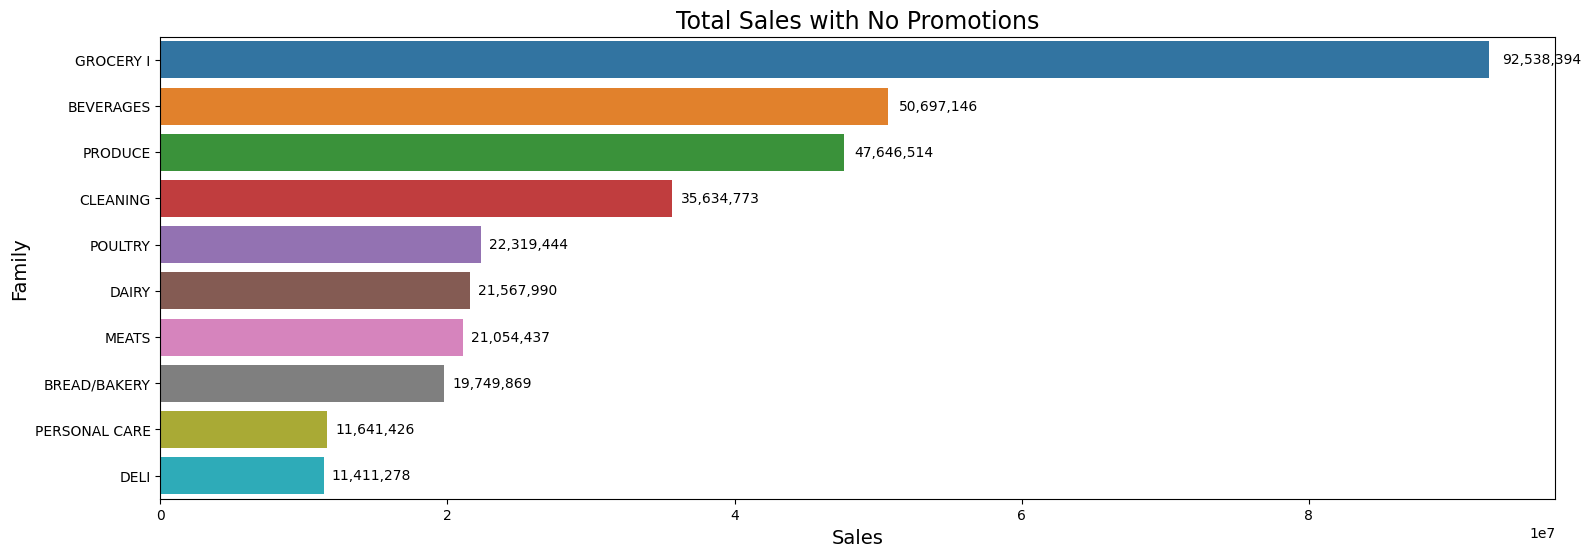

In [114]:
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=no_promotion_df, x='sales', y='family', palette='tab10', orient='h')

# Add bar labels with thousands separator and padding for visibility
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', ((p.get_width() * 1.005), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.title('Total Sales with No Promotions', fontsize=17)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Family', fontsize=14)
plt.show()


### Oil Prices Analysis

In [115]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [116]:
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [117]:
oil_df.set_index('date', inplace = True)
oil_df.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [118]:
oil_start_date = oil_df.index.min()
oil_end_date = oil_df.index.max()

print(f'Oil start date is {oil_start_date}')
print(f'Oil end date is {oil_end_date}')

Oil start date is 2013-01-01 00:00:00
Oil end date is 2017-08-31 00:00:00


In [119]:
date_range_start_date = date_range.min()
date_range_end_date = date_range.max()

print(f'Train start date is {date_range_start_date}')
print(f'Train end date is {date_range_end_date}')

Train start date is 2013-01-01 00:00:00
Train end date is 2017-08-15 00:00:00


In [120]:
date_range.size

1688

In [121]:
oil_df.index.size

1218

In [122]:
missing_oil_dates = date_range.difference(oil_df.index)
print(f'Total missing days: {missing_oil_dates.nunique()}')
missing_oil_dates

Total missing days: 482


DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-15', '2017-07-16', '2017-07-22', '2017-07-23',
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', length=482, freq=None)

In [123]:
missing_days_df = pd.DataFrame(missing_oil_dates, columns = ['date'])
missing_days_df

,date
0,2013-01-05
1,2013-01-06
2,2013-01-12
3,2013-01-13
4,2013-01-19
...,...
477,2017-07-30
478,2017-08-05
479,2017-08-06
480,2017-08-12


In [124]:
# Find out what days there are no valuesfor the oil data
#missing_days_df['Day of the week'] = missing_days_df['date'].apply(lambda x: x.strft)

# Assuming missing_dates is a DataFrame with a column named 'date'
missing_days_df['Day of the Week'] = missing_days_df['date'].apply(lambda x: x.strftime('%A'))
missing_days_df.set_index('date', inplace = True)


In [125]:
missing_days_df.head()

,Day of the Week
date,
2013-01-05,Saturday
2013-01-06,Sunday
2013-01-12,Saturday
2013-01-13,Sunday
2013-01-19,Saturday


In [126]:
missing_days_df['Day of the Week'].unique()

array(['Saturday', 'Sunday'], dtype=object)

- Dates with oil missing were on Saturday and sunday
- This mean that prices are not recorded on friday
- i will use the foward fill to fill the last recorded price on Fridaysince all prices do not flactuate

In [127]:
#oil prices missing from the original prices
oil_df.isna().sum()

dcoilwtico    43
dtype: int64

In [128]:
#oil prices missing from the missing dates
missing_days_df.isna().sum()

Day of the Week    0
dtype: int64

In [129]:
missing_days_df.isna().sum()


Day of the Week    0
dtype: int64

In [130]:
#all missing oil prices
full_oil_data = pd.concat([oil_df,missing_days_df])
full_oil_data.isna().sum()

dcoilwtico          525
Day of the Week    1218
dtype: int64

In [131]:
full_oil_data.drop('Day of the Week',axis = 1, inplace = True)


In [132]:
full_oil_data

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,NaN
2017-08-05,NaN
2017-08-06,NaN


In [133]:
full_oil_data['dcoilwtico']=full_oil_data['dcoilwtico'].fillna(method = 'ffill')
full_oil_data.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [134]:
full_oil_data.isna().sum() #The first value need to be manually filled since we used a ffill

dcoilwtico    1
dtype: int64

In [135]:
full_oil_data.loc['2013-01-01']

dcoilwtico   NaN
Name: 2013-01-01 00:00:00, dtype: float64

In [136]:
full_oil_data.loc['2013-01-01'] = 93.14

In [137]:
full_oil_data.isna().sum()

dcoilwtico    0
dtype: int64

In [138]:
# filtering out excess days since oil_df had 15 more days than train _df
excess_oil_days = full_oil_data[full_oil_data.index > '2017-08-15']
excess_oil_days

,dcoilwtico
date,
2017-08-16,46.80
2017-08-17,47.07
2017-08-18,48.59
2017-08-21,47.39
2017-08-22,47.65
2017-08-23,48.45
2017-08-24,47.24
2017-08-25,47.65
2017-08-28,46.40


In [139]:
#drop excess days as the oil dates since the oildata ended about 2 weeks after the sales data ended
full_oil_data_df = full_oil_data.drop(excess_oil_days.index,axis = 0)
full_oil_data_df

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,47.26
2017-08-05,47.26
2017-08-06,47.26


In [140]:
full_oil_data_df = full_oil_data_df.rename(columns = {'dcoilwtico': 'oil_price'})
full_oil_data_df

,oil_price
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-07-30,47.26
2017-08-05,47.26
2017-08-06,47.26


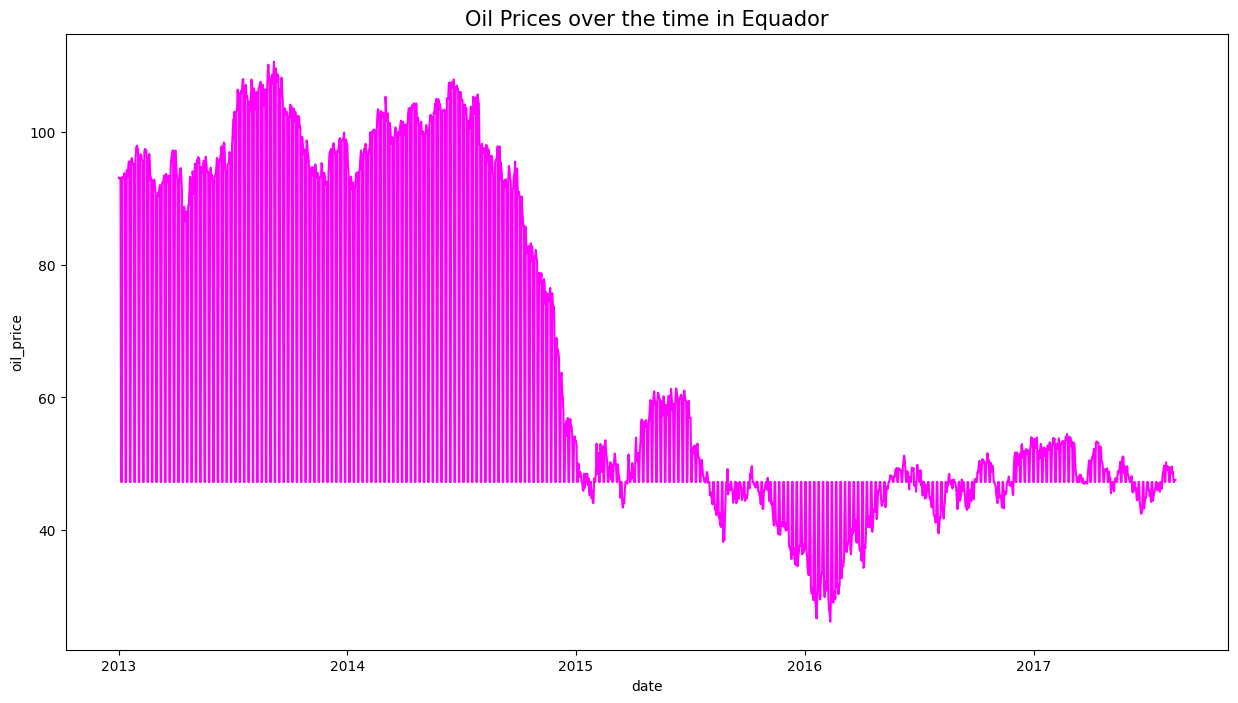

In [141]:
sns.lineplot(data = full_oil_data_df, x = full_oil_data_df.index, y = 'oil_price', color = 'magenta')
plt.title('Oil Prices over the time in Equador', fontsize = 15)
plt.show()

In [142]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [143]:
merged_with_oil_df = pd.merge(original_df, full_oil_data_df, on = 'date', how ='inner')
merged_with_oil_df

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date,oil_price
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01,93.14
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,25,POULTRY,172.52,0.00,August,8,2017,1,2017-08-15,47.57
2017-08-15,25,PLAYERS AND ELECTRONICS,3.00,0.00,August,8,2017,1,2017-08-15,47.57
2017-08-15,25,PET SUPPLIES,3.00,0.00,August,8,2017,1,2017-08-15,47.57


In [144]:
sales_by_oil_data = merged_with_oil_df.groupby(['date', 'oil_price'])['sales'].sum().reset_index()
sales_by_oil_data

,date,oil_price,sales
0,2013-01-01,93.14,2511.62
1,2013-01-02,93.14,496092.42
2,2013-01-03,92.97,361461.23
3,2013-01-04,93.12,354459.68
4,2013-01-05,47.26,477350.12
...,...,...,...
1683,2017-08-11,48.81,826373.72
1684,2017-08-12,47.26,792630.54
1685,2017-08-13,47.26,865639.68
1686,2017-08-14,47.59,760922.41


In [145]:
#Select the 7 highest oil prices - this will be a week of data
high_oil_prices = sales_by_oil_data.nlargest(7, 'oil_price')
high_oil_prices['price_category'] = 'High'
high_oil_prices

,date,oil_price,sales,price_category
248,2013-09-06,110.62,335442.25,High
239,2013-08-28,110.17,319322.06,High
251,2013-09-09,109.62,377151.71,High
238,2013-08-27,109.11,319688.22,High
254,2013-09-12,108.72,282855.73,High
245,2013-09-03,108.67,397680.42,High
240,2013-08-29,108.51,294518.69,High


In [146]:
# select the 7 lowest oil prices - this will be a week of data
low_oil_prices = sales_by_oil_data.nsmallest(7,'oil_price')
low_oil_prices['price_category'] = 'Low'
low_oil_prices

,date,oil_price,sales,price_category
1136,2016-02-11,26.19,646376.37,Low
1114,2016-01-20,26.68,738744.01,Low
1135,2016-02-10,27.54,790988.71,Low
1134,2016-02-09,27.96,746939.64,Low
1113,2016-01-19,28.47,630929.75,Low
1141,2016-02-16,29.05,719111.89,Low
1137,2016-02-12,29.32,698152.07,Low


In [147]:
merged_df = pd.concat([high_oil_prices, low_oil_prices])
merged_df


,date,oil_price,sales,price_category
248,2013-09-06,110.62,335442.25,High
239,2013-08-28,110.17,319322.06,High
251,2013-09-09,109.62,377151.71,High
238,2013-08-27,109.11,319688.22,High
254,2013-09-12,108.72,282855.73,High
245,2013-09-03,108.67,397680.42,High
240,2013-08-29,108.51,294518.69,High
1136,2016-02-11,26.19,646376.37,Low
1114,2016-01-20,26.68,738744.01,Low
1135,2016-02-10,27.54,790988.71,Low


In [148]:

# Group by price category
grouped_df = merged_df.groupby('price_category')

# Calculate summary statistics for each group
oil_merged_df = grouped_df.agg({
    'oil_price': 'mean',
    'sales': 'mean'
})

oil_merged_df

,oil_price,sales
price_category,,
High,109.35,332379.87
Low,27.89,710177.49


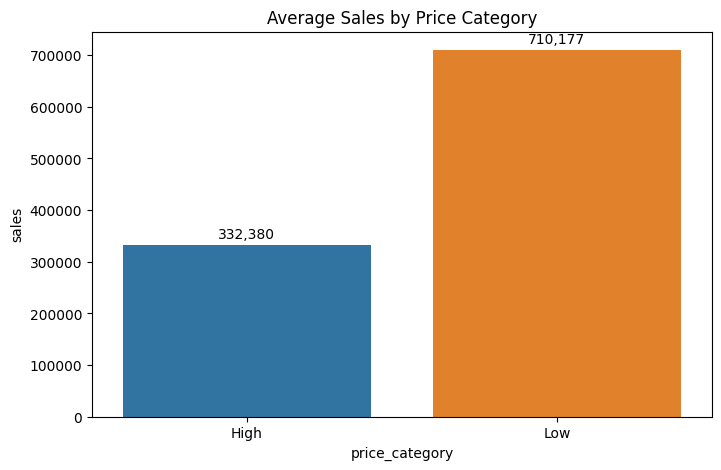

In [149]:
plt.figure(figsize =(8,5))
ax = sns.barplot(data = oil_merged_df, x = 'price_category',y = 'sales', hue ='price_category')

for container in ax.containers:
    ax.bar_label(container,fmt = '{:,.0f}', padding = 3)

plt.title('Average Sales by Price Category')
plt.show()

### Holidy Analysis

In [150]:
holiday_events_df.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [151]:
# Convert date to datetime
holiday_events_df['date'] = pd.to_datetime(holiday_events_df['date'])
holiday_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [152]:
holiday_events_df.set_index('date', inplace = True)
holiday_events_df.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [153]:
holiday_events_start_date = holiday_events_df.index.min()
holiday_events_end_date = holiday_events_df.index.max()

In [154]:
#Get the date between which holiday events were recorded
print(f'Holiday events start date is {holiday_events_start_date}')
print(f'Holiday events end date is {holiday_events_end_date}')

Holiday events start date is 2012-03-02 00:00:00
Holiday events end date is 2017-12-26 00:00:00


In [155]:
date_range.size

1688

In [156]:
holiday_events_df.index.size

350

In [157]:
date_range_start_date = date_range.min()
date_range_end_date = date_range.max()

print(f'Train start date is {date_range_start_date}')
print(f'Train end date is {date_range_end_date}')

Train start date is 2013-01-01 00:00:00
Train end date is 2017-08-15 00:00:00


In [158]:
missing_holiday_dates = date_range.difference(holiday_events_df.index)
print(f'Total missing days: {missing_holiday_dates.nunique()}')
missing_holiday_dates

Total missing days: 1432


DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-06',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-13',
               ...
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1432, freq=None)

In [159]:
missing_holiday_days_df = pd.DataFrame(missing_holiday_dates, columns = ['date'])
missing_holiday_days_df

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-06
4,2013-01-07
...,...
1427,2017-08-08
1428,2017-08-09
1429,2017-08-12
1430,2017-08-13


In [160]:
# Find out what days there are no valuesfor the oil data
#missing_days_df['Day of the week'] = missing_days_df['date'].apply(lambda x: x.strft)

# Assuming missing_dates is a DataFrame with a column named 'date'
missing_holiday_days_df['Day of the Week'] = missing_holiday_days_df['date'].apply(lambda x: x.strftime('%A'))
missing_holiday_days_df.set_index('date', inplace = True)

In [161]:
missing_holiday_days_df

,Day of the Week
date,
2013-01-02,Wednesday
2013-01-03,Thursday
2013-01-04,Friday
2013-01-06,Sunday
2013-01-07,Monday
...,...
2017-08-08,Tuesday
2017-08-09,Wednesday
2017-08-12,Saturday


In [162]:
missing_holiday_days_df['Day of the Week'].unique()

array(['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday',
       'Saturday'], dtype=object)

- We have missing holiday days in every day of the week
- there are 350 holidays recorded
- we will inner merge holiday events data to full data to show the effect of holidys on prices

In [164]:
holiday_events_df.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [165]:

#all missing oil prices
full_holiday_data = pd.concat([holiday_events_df,missing_holiday_days_df])
full_holiday_data.isna().sum()

type               1432
locale             1432
locale_name        1432
description        1432
transferred        1432
Day of the Week     350
dtype: int64

In [166]:
full_holiday_data

,type,locale,locale_name,description,transferred,Day of the Week
date,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,NaN
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NaN
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,NaN
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,NaN
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,NaN
...,...,...,...,...,...,...
2017-08-08,NaN,NaN,NaN,NaN,NaN,Tuesday
2017-08-09,NaN,NaN,NaN,NaN,NaN,Wednesday
2017-08-12,NaN,NaN,NaN,NaN,NaN,Saturday


In [167]:
# Reset index to convert 'date' column back to a regular column
full_holiday_data.reset_index(inplace=True)

# Drop all features apart from 'type' and 'date'
full_holiday_data = full_holiday_data[['type', 'date']]

# Display the resulting dataframe
print(full_holiday_data.head())


      type       date
0  Holiday 2012-03-02
1  Holiday 2012-04-01
2  Holiday 2012-04-12
3  Holiday 2012-04-14
4  Holiday 2012-04-21


In [168]:
full_holiday_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event',
       nan], dtype=object)

In [169]:
# Fill missing values in 'type' column with 'non-holiday'
full_holiday_data['type'].fillna('N/A', inplace=True)

# Display the updated dataframe
print(full_holiday_data.tail())


     type       date
1777  N/A 2017-08-08
1778  N/A 2017-08-09
1779  N/A 2017-08-12
1780  N/A 2017-08-13
1781  N/A 2017-08-14


In [170]:
merged_with_oil_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date,oil_price
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01,93.14
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01,93.14


In [171]:


# Perform inner merge
merged_df = pd.merge(full_holiday_data, merged_with_oil_df, how='inner', left_on='date', right_index=True)

# Display the resulting dataframe
#print(merged_df.head())


In [172]:
# Group sales by 'date', 'type', and 'oil_price', and calculate the sum of sales
grouped_holiday_sales = merged_df.groupby(['date', 'type', 'oil_price'])['sales'].sum().reset_index()

# Display the resulting dataframe
grouped_holiday_sales 


,date,type,oil_price,sales
0,2013-01-01,Holiday,93.14,2511.62
1,2013-01-02,N/A,93.14,496092.42
2,2013-01-03,N/A,92.97,361461.23
3,2013-01-04,N/A,93.12,354459.68
4,2013-01-05,Work Day,47.26,477350.12
...,...,...,...,...
1696,2017-08-11,Transfer,48.81,826373.72
1697,2017-08-12,N/A,47.26,792630.54
1698,2017-08-13,N/A,47.26,865639.68
1699,2017-08-14,N/A,47.59,760922.41


In [173]:
# Group data by 'type' and calculate the sum of 'oil_price' and 'sales' for each type
grouped_by_type = grouped_holiday_sales.groupby('type').agg({'oil_price': 'mean', 'sales': 'mean'}).reset_index()

# Display the resulting dataframe
grouped_by_type


,type,oil_price,sales
0,Additional,57.67,868954.74
1,Bridge,50.46,796110.02
2,Event,55.02,772317.62
3,Holiday,61.51,686935.02
4,N/A,62.44,627547.66
5,Transfer,59.38,833536.04
6,Work Day,47.26,663184.71


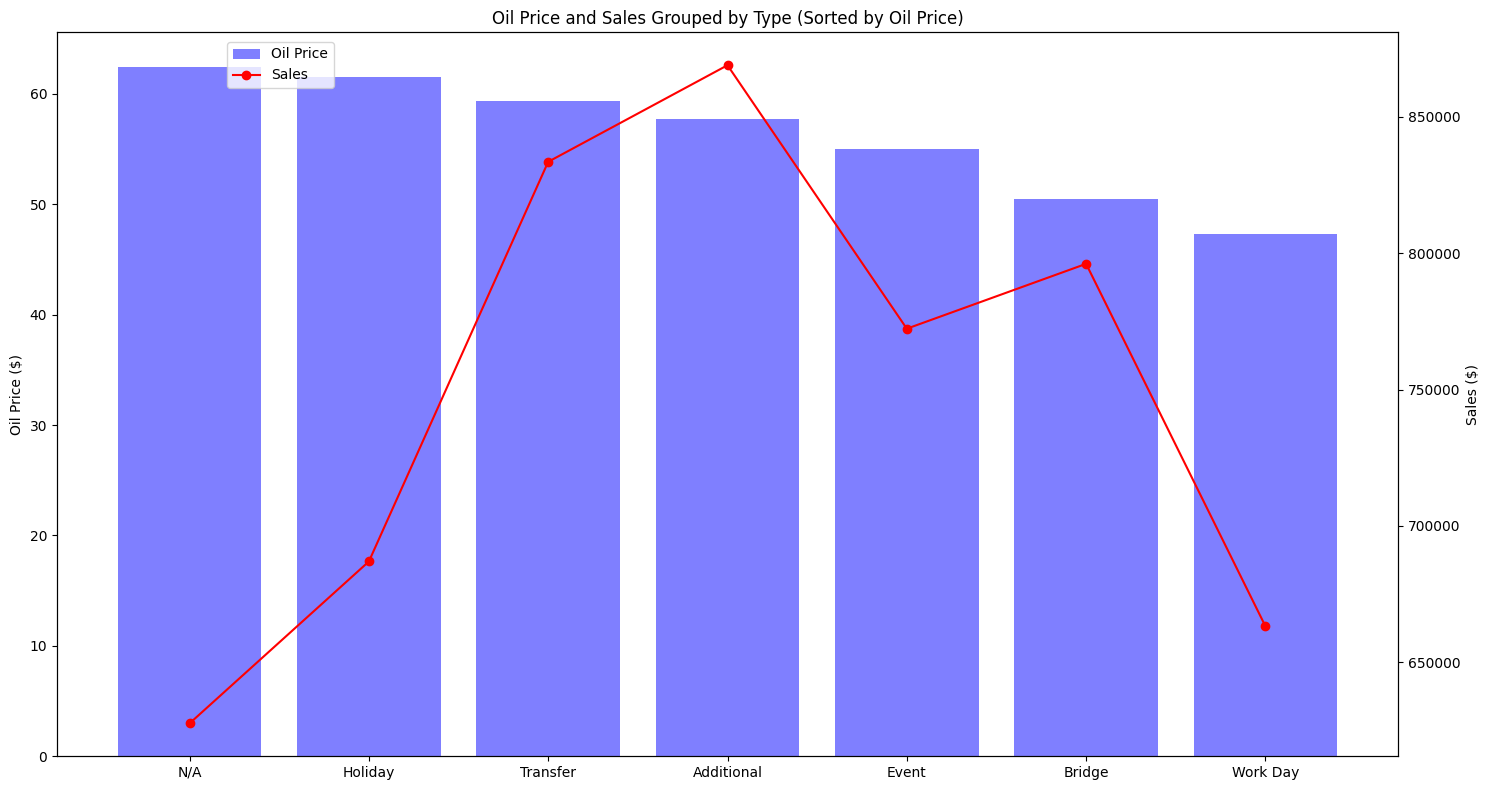

In [174]:


# Data
data = {
    'type': ['Additional', 'Bridge', 'Event', 'Holiday', 'N/A', 'Transfer', 'Work Day'],
    'oil_price': [57.67, 50.46, 55.02, 61.51, 62.44, 59.38, 47.26],
    'sales': [868954.74, 796110.02, 772317.62, 686935.02, 627547.66, 833536.04, 663184.71]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Sorting DataFrame by oil prices
df_sorted = df.sort_values(by='oil_price',ascending=False)

# Create figure and axes
fig, ax1 = plt.subplots()

# Plotting oil prices
ax1.bar(df_sorted['type'], df_sorted['oil_price'], color='b', alpha=0.5, label='Oil Price')
ax1.set_ylabel('Oil Price ($)')
ax1.tick_params(axis='y')

# Creating a secondary y-axis for sales
ax2 = ax1.twinx()
ax2.plot(df_sorted['type'], df_sorted['sales'], color='r', marker='o', label='Sales')
ax2.set_ylabel('Sales ($)')
ax2.tick_params(axis='y')

# Adding legend
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.95))

# Title and labels
plt.title('Oil Price and Sales Grouped by Type (Sorted by Oil Price)')
plt.xlabel('Type')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


6. What analysis can we get from the date and its extractable features?

In [175]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [176]:
original_df.head()

,store_nbr,family,sales,onpromotion,month_name,month,year,day,sales_date
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,CELEBRATION,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BREAD/BAKERY,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BOOKS,0.00,0.00,January,1,2013,1,2013-01-01
2013-01-01,42,BEVERAGES,0.00,0.00,January,1,2013,1,2013-01-01


In [177]:
# Check for missing values
print("\nMissing values:")
print(original_df.isnull().sum())


Missing values:
store_nbr      0
family         0
sales          0
onpromotion    0
month_name     0
month          0
year           0
day            0
sales_date     0
dtype: int64


In [179]:
# Explore data types
print("\nData types:")
print(original_df.dtypes)


Data types:
store_nbr               int64
family                 object
sales                 float64
onpromotion           float64
month_name             object
month                   int32
year                    int32
day                     int32
sales_date     datetime64[ns]
dtype: object


In [180]:
# 2. Data Preparation
# Convert 'sales_date' column to datetime format
original_df['sales_date'] = pd.to_datetime(original_df['sales_date'])

In [181]:
# Extract relevant time features
original_df['year'] = original_df['sales_date'].dt.year
original_df['month'] = original_df['sales_date'].dt.month
original_df['day'] = original_df['sales_date'].dt.day

In [182]:
# 3. Daily Sales Analysis
# Calculate total daily sales
daily_sales = original_df.groupby('sales_date')['sales'].sum()

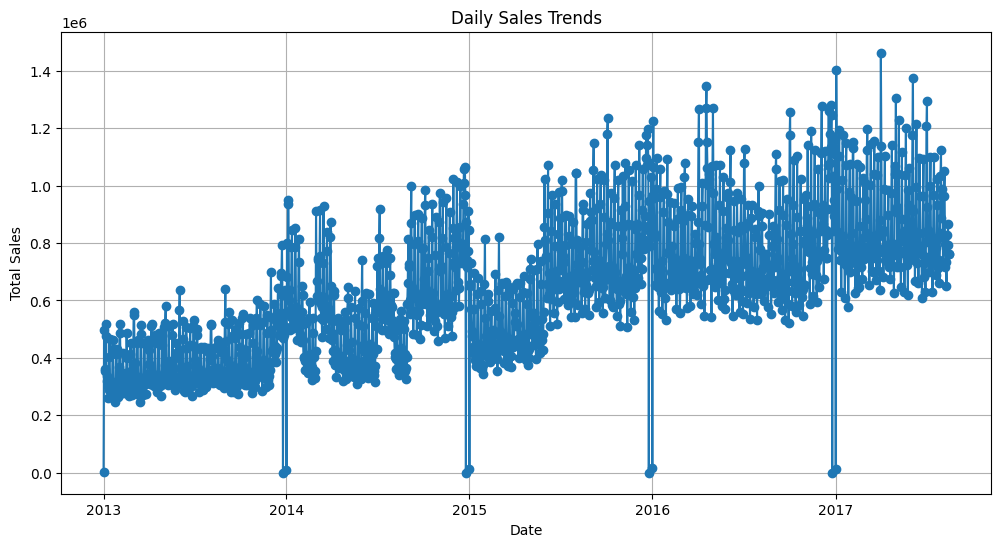

In [183]:

# Visualize daily sales trends over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-')
plt.title('Daily Sales Trends')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [184]:
# 4. Monthly Sales Analysis
# Calculate total monthly sales
monthly_sales = original_df.groupby(['year', 'month'])['sales'].sum()

In [186]:
# 4. Monthly Sales Analysis
# Calculate total monthly sales
monthly_sales = original_df.groupby(['year', 'month'])['sales'].sum()

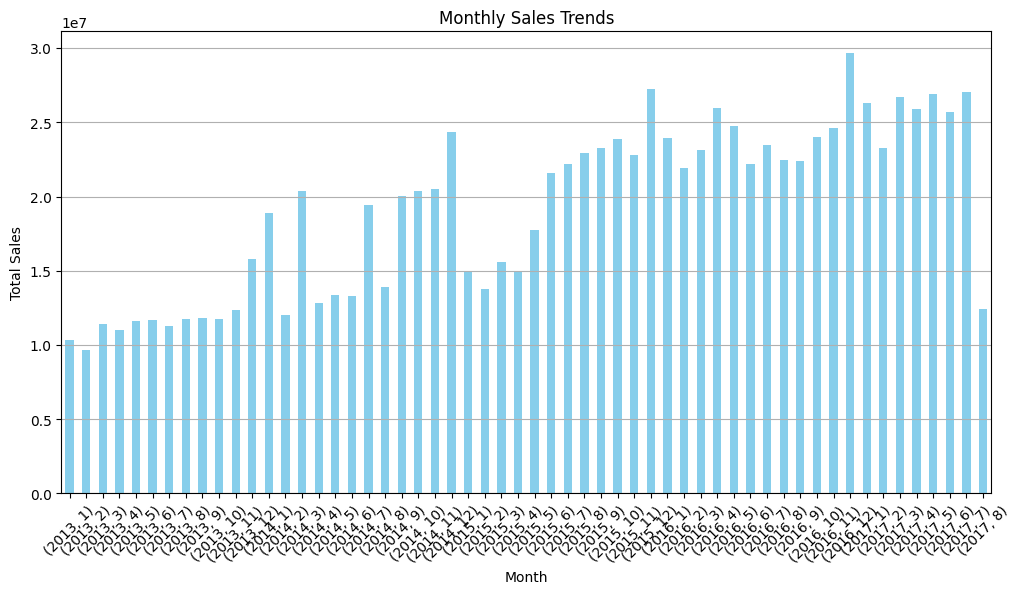

In [187]:
# Visualize monthly sales trends over time
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [189]:

# 5. Quarterly Sales Analysis (Optional)
# Calculate total quarterly sales
quarterly_sales = original_df.groupby(['year', pd.PeriodIndex(original_df['sales_date'], freq='Q')])['sales'].sum()

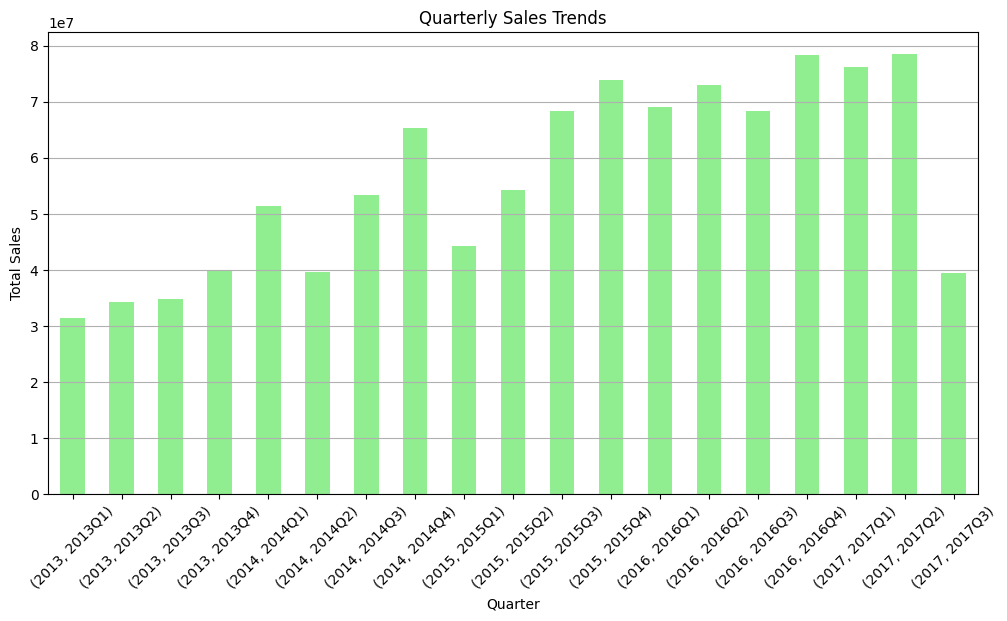

In [190]:
# Visualize quarterly sales trends over time
plt.figure(figsize=(12, 6))
quarterly_sales.plot(kind='bar', color='lightgreen')
plt.title('Quarterly Sales Trends')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [191]:
# 6. Yearly Sales Analysis
# Calculate total yearly sales
yearly_sales = original_df.groupby('year')['sales'].sum()

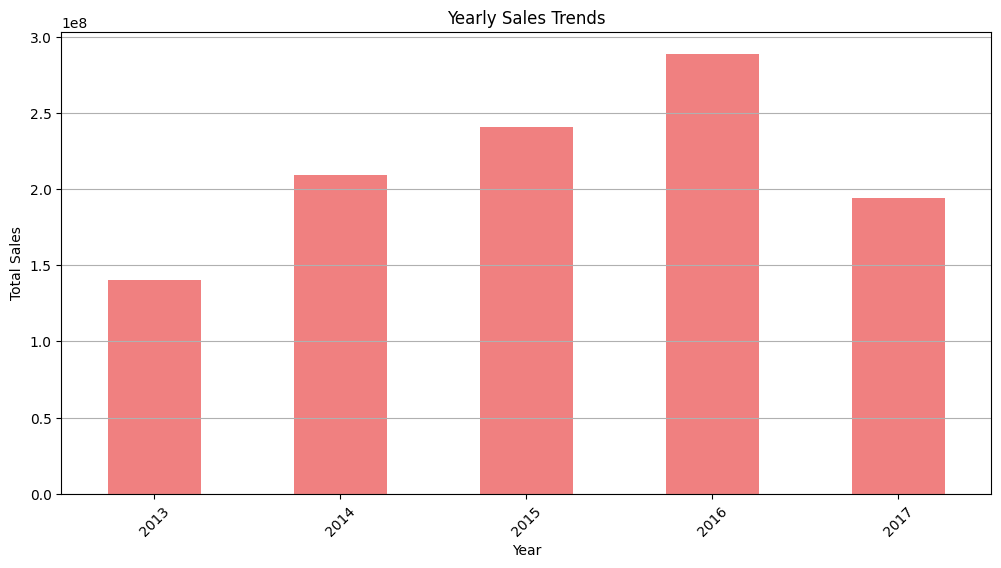

In [192]:



# Visualize yearly sales trends over time
plt.figure(figsize=(12, 6))
yearly_sales.plot(kind='bar', color='lightcoral')
plt.title('Yearly Sales Trends')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

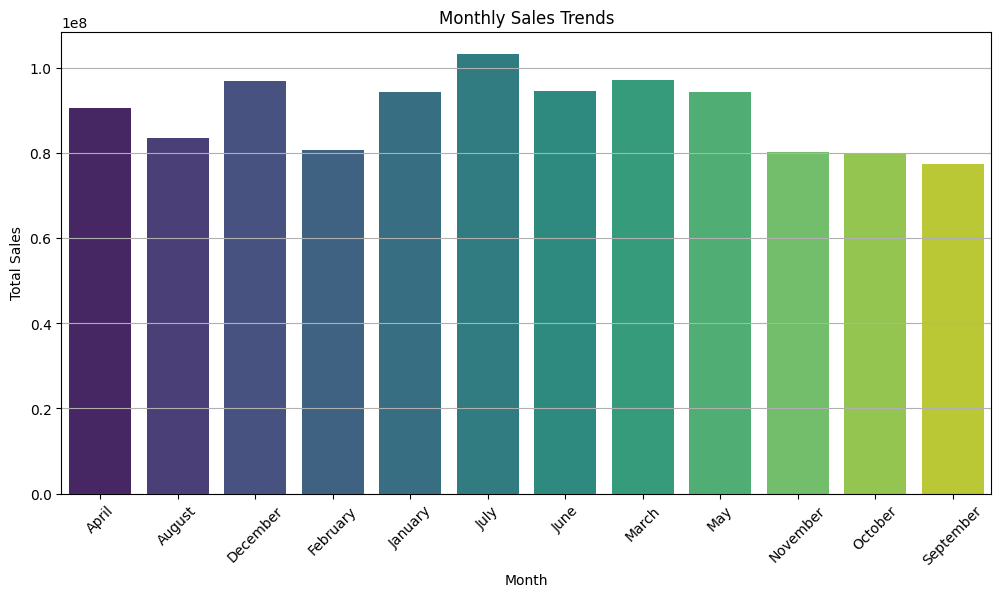

In [193]:

# 3. Monthly Sales Analysis
# Calculate total sales for each month
monthly_sales = original_df.groupby('month_name')['sales'].sum().reset_index()

# Visualize monthly sales trends
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x='month_name', y='sales', palette='viridis')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

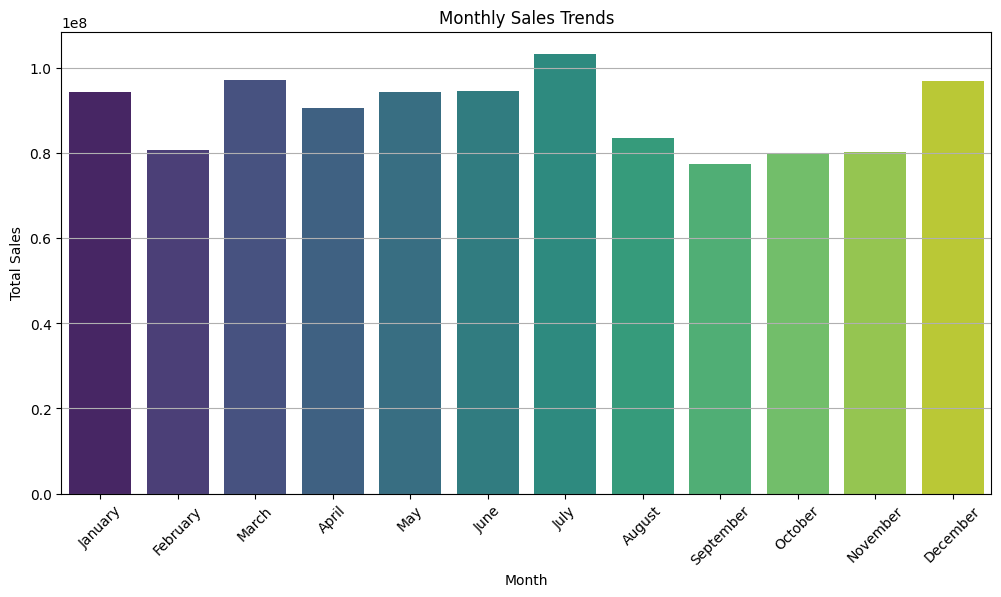

In [195]:

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Calculate total sales for each month
monthly_sales = original_df.groupby('month_name')['sales'].sum().reindex(month_order).reset_index()

# Visualize monthly sales trends
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_sales, x='month_name', y='sales', palette='viridis', order=month_order)
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


7. Which product family and stores did the promotions affect?

In [196]:
# Filter DataFrame to include only rows where promotions were active
promotions_df = original_df[original_df['onpromotion'] == 1]

# Get unique product families and stores affected by promotions
affected_families = promotions_df['family'].unique()
affected_stores = promotions_df['store_nbr'].unique()

print("Product families affected by promotions:", affected_families)
print('%'*80)
print("Stores affected by promotions:", affected_stores)


Product families affected by promotions: ['POULTRY' 'GROCERY I' 'BREAD/BAKERY' 'FROZEN FOODS' 'CLEANING'
 'BEVERAGES' 'EGGS' 'PREPARED FOODS' 'DAIRY' 'DELI' 'MEATS'
 'HOME APPLIANCES' 'PERSONAL CARE' 'SEAFOOD' 'LINGERIE' 'PRODUCE'
 'LAWN AND GARDEN' 'BEAUTY' 'AUTOMOTIVE' 'LIQUOR,WINE,BEER' 'GROCERY II'
 'HARDWARE' 'HOME CARE' 'PLAYERS AND ELECTRONICS' 'CELEBRATION'
 'HOME AND KITCHEN I' 'LADIESWEAR' 'HOME AND KITCHEN II' 'PET SUPPLIES'
 'MAGAZINES' 'SCHOOL AND OFFICE SUPPLIES' 'BABY CARE']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Stores affected by promotions: [ 9 39 18 28  6  3  2  8 38 41 23 12 10 13 15 14 16 33 30 19 17 35 43 40
 32 11 54 34 31 36  7 48 37 27  5 45 25 26  4 53 50 46 47 49 44  1 51 24
 20 29 21 42 22 52]


In [197]:
# Merge train data with promotions and analyze effect on product family and stores

promotion_effect = original_df.groupby(['family', 'store_nbr'])['onpromotion'].sum().reset_index()
# Aggregate the effect of promotion on different product families
promotion_aggregated = promotion_effect.groupby('family')['onpromotion'].sum().reset_index()
# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='onpromotion', ascending=False)

promotion_aggregated.head()

,family,onpromotion
12,GROCERY I,1914801.00
30,PRODUCE,1117921.00
3,BEVERAGES,906958.00
8,DAIRY,728707.00
7,CLEANING,661157.00


In [198]:
# Merge train data with promotions and analyze effect on product family, stores, and sales
promotion_effect = original_df.groupby(['family', 'store_nbr'])[['onpromotion', 'sales']].sum().reset_index()

# Aggregate the effect of promotion on different product families and sales
promotion_aggregated = promotion_effect.groupby('family')[['onpromotion', 'sales']].sum().reset_index()

# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='onpromotion', ascending=False)

promotion_aggregated.head()


,family,onpromotion,sales
12,GROCERY I,1914801.00,343462734.89
30,PRODUCE,1117921.00,122704684.68
3,BEVERAGES,906958.00,216954486.00
8,DAIRY,728707.00,64487709.00
7,CLEANING,661157.00,97521289.00


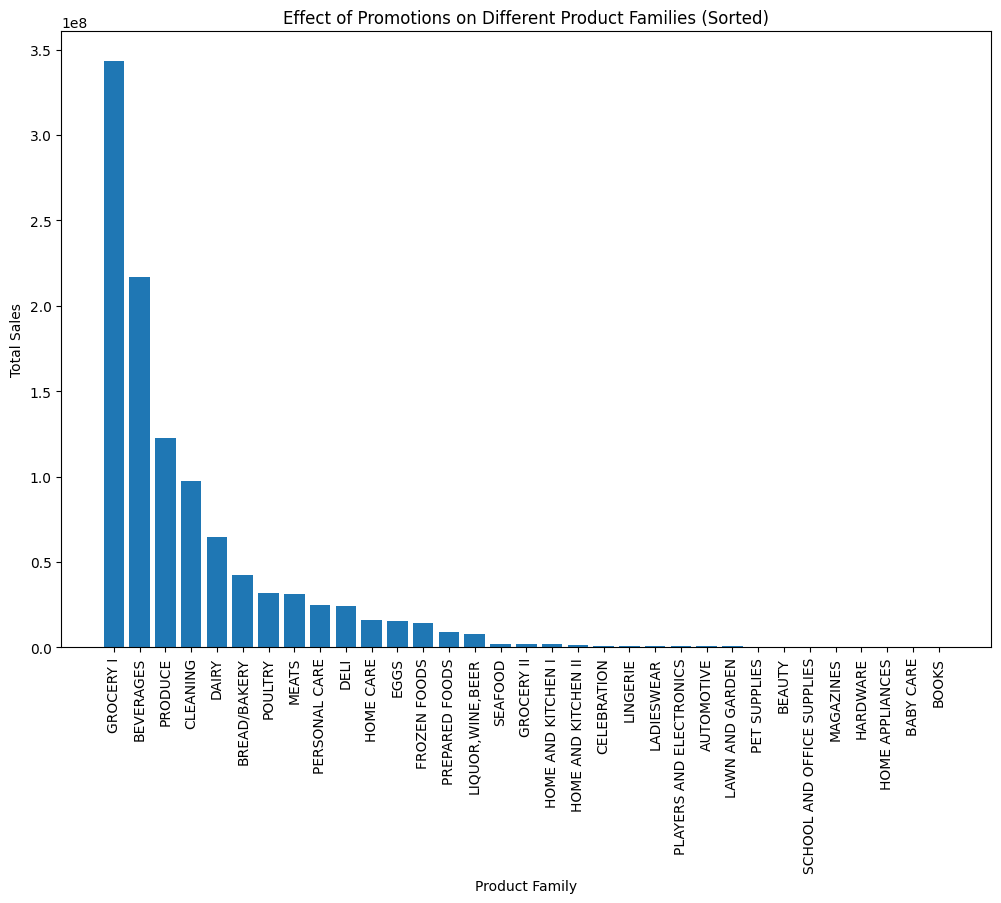

In [199]:
# Aggregate the effect of promotion on different product families
promotion_aggregated = promotion_effect.groupby('family')['sales'].sum().reset_index()

# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='sales', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(promotion_aggregated['family'], promotion_aggregated['sales'])
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.title('Effect of Promotions on Different Product Families (Sorted)')
plt.xticks(rotation=90)
plt.show()

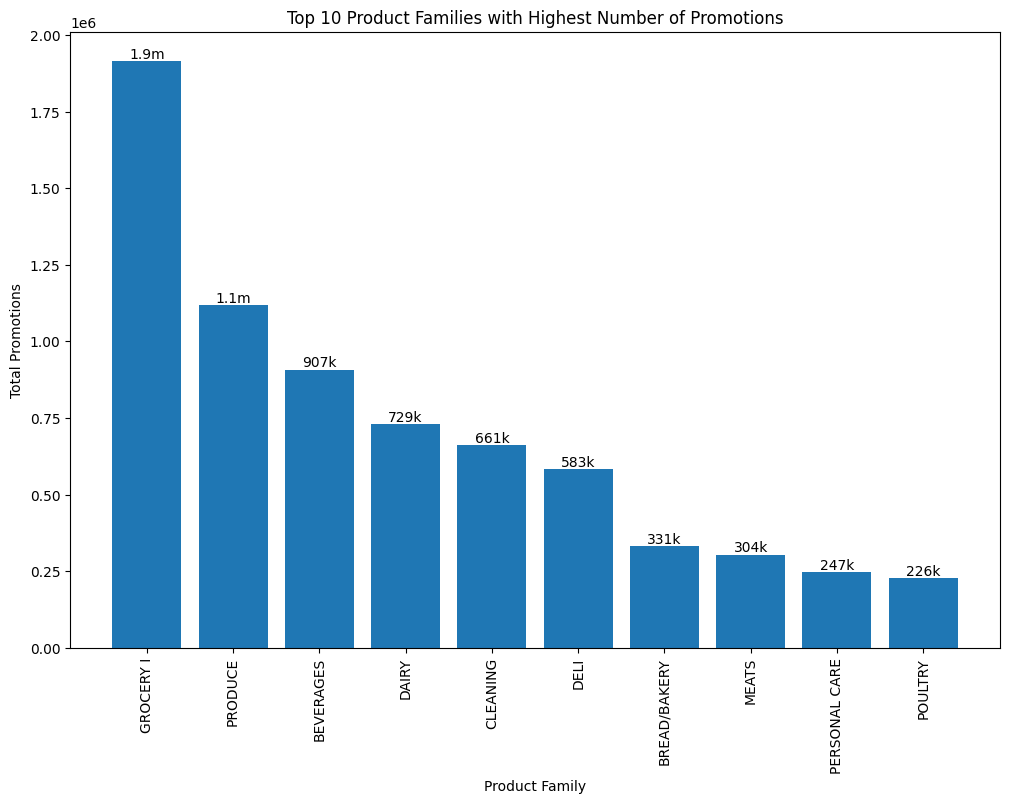

In [200]:


# Function to format numbers
def format_number(num):
    if num >= 1e6:
        return f'{num / 1e6:.1f}m'
    elif num >= 1e3:
        return f'{num / 1e3:.0f}k'
    else:
        return f'{num}'

# Aggregate the effect of promotion on different product families
promotion_aggregated = promotion_effect.groupby('family')['onpromotion'].sum().reset_index()

# Sort by total promotions
promotion_aggregated = promotion_aggregated.sort_values(by='onpromotion', ascending=False)

# Selecting top 10 product families
top_10 = promotion_aggregated.head(10)

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(top_10['family'], top_10['onpromotion'])
plt.xlabel('Product Family')
plt.ylabel('Total Promotions')
plt.title('Top 10 Product Families with Highest Number of Promotions')
plt.xticks(rotation=90)

# Adding values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, format_number(yval), va='bottom', ha='center')

plt.show()

